In [1]:
from notebook_importer import *
import Commons

importing notebook from Commons.ipynb


In [2]:
cluster_speed = {
    'SO': 0, 'AO': 0, 'ET': 0, 'MU': 1,
    'BF': 0, 'DJ': 0, 'BI': 1, 'BJ': 2, 'BW': 3, 'DZ': 2, 'TZ': 1, 'NA': 3, 'NG': 0, 'TN': 2, 'LR': 2, 'LS': 3, 'TG': 0, 'TD': 0, 'LY': 2, 'ZM': 3, 'CI': 0, 'CM': 0, 'EG': 2, 'ZA': 3, 'CD': 0, 'GA': 0, 'GM': 0, 'ZW': 3, 'GH': 0, 'MG': 2, 'MA': 2, 'KE': 1, 'ML': 2, 'MW': 3, 'SO': 0, 'SN': 2, 'SL': 0, 'SC': 2, 'UG': 1, 'MZ': 3, 'SD': 2}

In [567]:
import json
import requests

j = requests.get('http://simon.lacnic.net/static/results-africa-connectivity-traces.json').text
trs_speed = json.loads(j)

In [563]:
from collections import defaultdict
import numpy as np

hops_origin = defaultdict(lambda: defaultdict(list))
for trace in trs_speed:
    hops_origin[trace['country_origin']][trace['country_destination']].append(trace['hop_count'])

banned = []
hops = defaultdict(lambda: defaultdict(float))
for o, D in hops_origin.iteritems():
    
#     if len(_list) < 10:
#         banned.append(o)
        
    for d, _list in D.iteritems():
        hops[o][d] = np.median(_list)

## Interdomain hops

In [568]:
hops_origin_interdomain = defaultdict(lambda: defaultdict(list))
for trace in trs_speed:
    hop_count = len(set([h['as_destination'] for h in trace['hops']]))
    hops_origin_interdomain[trace['country_origin']][trace['country_destination']].append(hop_count)

In [576]:
clusters_hops = defaultdict(list)

for cc, D in hops_origin_interdomain.iteritems():
    try:
        clusters_hops[cluster_speed[cc]] += [item for sublist in D.values() for item in sublist]
    except:
        pass

In [6]:
hops_origin_overseas = defaultdict(lambda: defaultdict(list))
for trace in trs_speed:
    in_ccs = [h['country_destination'] in Commons.ccs for h in trace['hops'] if h['country_destination'] != 'XX']  # XX?
    hops_origin_overseas[trace['country_origin']][trace['country_destination']] += in_ccs

In [7]:
# ?
# 'JE' apparently is in Europe

for cc in ['BR']:
    cluster_speed[cc] = 5

# US
for cc in ['US', 'CA']:
    cluster_speed[cc] = 6

# Europe
for cc in ['BE', 'FR', 'BG', 'DE', 'NL', 'PT', 'RO', 'IT', 'CZ', 'GB', 'IE', 'ES', 'AT', 'JE', 'CH']:
    cluster_speed[cc] = 7
    
# Arab Emirates
for cc in ['AE', 'SA']:
    cluster_speed[cc] = 8

# Asia
for cc in ['MY', 'IN', 'SG', 'AU', 'CN']:
    cluster_speed[cc] = 9

In [8]:
ignored =[
    'CF',
    'GN',
    'ST',
    'NE',
    'YT',
    'GQ',
    'MR',
    'KM',
    'SZ',
#     'AO',
    'CV',
#     'ET',
    'RW',
    'RE',
    'CG',
#     'MU'
]

In [9]:
hops_first_interdomain_hop = defaultdict(lambda: defaultdict(list))
countries = []
for tr in trs_speed:
    first_hop = tr['as_origin']
    for h in tr['hops']:
        current_hop = h['as_destination']
        if current_hop == first_hop:
            continue
            
        cc_o = tr['country_origin']
        cc_d = h['country_destination']
        if cc_d == 'XX' or cc_o in ignored or cc_d in ignored:
            break
            
        if cc_d not in Commons.ccs:
            countries.append(h['country_destination'])
        
        clus_o = cluster_speed[cc_o]
        clus_d = cluster_speed[cc_d]
        
        rtt = h['min_rtt']
        if rtt <= .0:
            break
        hops_first_interdomain_hop[clus_o][clus_d].append(rtt)
        break

In [10]:
xticklabels = {
    0 : "Western",
    1 : "Eastern",
    2 : "Northern",
    3 : "Southern"
}
# xticklabels[0] = 'W'
# xticklabels[1] = 'E'
# xticklabels[2] = 'N'
# xticklabels[3] = 'S'
xticklabels[5] = 'S. America'
xticklabels[6] = 'N. America'
xticklabels[7] = 'Europe'
xticklabels[8] = 'Arabia'
xticklabels[9] = 'Asia'

In [11]:
import json

with open('restcountries.json') as f:
    restcountries = json.loads(f.read())

In [12]:
from collections import defaultdict

names = defaultdict(str)

for rest in restcountries:
    names[rest['alpha2Code']] = rest['name']
    
def get_name_from_cc(cc):
    try:
        return names[cc]
    except KeyError as ke:
        return 'XX'

In [13]:
import networkx as nx

g = nx.DiGraph()
g_ccs = nx.DiGraph()

countries = []
for tr in trs_speed[:]:
    previous_hop = tr['as_origin']
    
    cc_o = tr['country_origin']
    if cc_o in ignored: continue
        
    clus_o = str(xticklabels[cluster_speed[cc_o]]) + " %d" % 0
    cc_o_key = "%s %d" % (cc_o, 0)
    
    i = 0
    for h in (tr['hops']):
        try:
            current_hop = h['as_destination']

            if current_hop == previous_hop:
                continue

            i += 1
            cc_d = h['country_destination']
            if cc_d == 'XX' or cc_d == 'LB' or cc_d == 'GP' or cc_d == 'SE':
                clus_d = 'Clus. XX'
            else:
                clus_d = str(xticklabels[cluster_speed[cc_d]]) + " %d" % i

            rtt = h['min_rtt']
            if (clus_o, clus_d) not in g.edges():
                g.add_edge(clus_o, clus_d, weight=1, rtt=[rtt])
            else:
                g[clus_o][clus_d]['weight'] += 1
                g[clus_o][clus_d]['rtt'].append(rtt)
                
#             Country-level graph
            cc_d_key = "%s %d" % (cc_d, i)
            if (cc_o_key, cc_d_key) not in g_ccs.edges():
                g_ccs.add_edge(cc_o_key, cc_d_key, weight=1, rtt=[rtt])
            else:
                g_ccs[cc_o_key][cc_d_key]['weight'] += 1
                g_ccs[cc_o_key][cc_d_key]['rtt'].append(rtt)
                
        except KeyError as ke:
            print ke, get_name_from_cc(cc_d)
#             break
        finally:
            clus_o = clus_d
            cc_o = cc_d
            cc_o_key = cc_d_key
            previous_hop = current_hop

g.remove_node('Clus. XX')

u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'CG' Republic of the Congo
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'CG' Republic of the Congo
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'CG' Republic of the Congo
u'CG' Republic of

In [14]:
g.remove_edges_from([e for e in g.edges() if int(e[0][-1]) >= int(e[1][-1])])

In [15]:
g.remove_nodes_from([n for n in g.nodes() if 'Rw' in n])

In [16]:
list(nx.simple_cycles(g))

[]

In [455]:
for e in g.edges():
    if int(e[1][-1]) >= 4:
        continue
    print "['%s', '%s', %d]," % (e[0], e[1], g[e[0]][e[1]]['weight'])

['Asia 1', 'Western 2', 29],
['Asia 1', 'Eastern 2', 100],
['Asia 1', 'Europe 2', 223],
['Asia 2', 'Western 3', 12],
['Asia 2', 'Europe 3', 146],
['Asia 2', 'Asia 3', 7],
['Western 2', 'Northern 3', 17],
['Western 2', 'Europe 3', 214],
['Western 2', 'Western 3', 329],
['Western 2', 'Eastern 3', 14],
['Western 2', 'Southern 3', 26],
['Western 1', 'Northern 2', 20],
['Western 1', 'Europe 2', 555],
['Western 1', 'Asia 2', 145],
['Western 1', 'Western 2', 807],
['Western 1', 'Southern 2', 83],
['Western 1', 'N. America 2', 220],
['Western 0', 'Northern 1', 219],
['Western 0', 'Asia 1', 36],
['Western 0', 'Europe 1', 2004],
['Western 0', 'Eastern 1', 258],
['Western 0', 'Western 1', 842],
['Western 0', 'N. America 1', 647],
['Western 0', 'Southern 1', 1091],
['Northern 0', 'Northern 1', 1309],
['Northern 0', 'Asia 1', 146],
['Northern 0', 'Europe 1', 5015],
['Northern 0', 'Arabia 1', 412],
['Northern 0', 'Eastern 1', 544],
['Northern 0', 'Western 1', 579],
['Northern 0', 'N. America 1', 174

In [74]:
g_rtt = nx.Graph()  # undir
for e in g.edges():
    try:
        median = float(np.median([r for r in g[e[0]][e[1]]['rtt'] if r > 0]))
        if median > 0.0:
            g_rtt.add_edge(e[0], e[1], rtt=median)
            
    except KeyError as ke:
        print ke
        continue

dijk_paths = defaultdict(lambda: defaultdict(float))
i = 0
for orig in ['Western 0', 'Eastern 0', 'Northern 0', 'Southern 0']:
    j = 0
    for dest in ['Western 1', 'Eastern 1', 'Northern 1', 'Southern 1']:
        before = np.median([r for r in g[orig][dest]['rtt'] if r > 0])
        path = nx.dijkstra_path(g_rtt, source=orig, target=dest, weight='rtt')
        after = nx.dijkstra_path_length(g_rtt, source=orig, target=dest, weight='rtt')
        print orig, dest, "%.1f%%" % (100.0*(before-after)/before), path
        j += 1
#         dijk_paths[i][j]['before'] = np.median([r for r in g[orig][dest]['rtt'] if r > 0])
    i += 1

Western 0 Western 1 0.0% ['Western 0', 'Western 1']
Western 0 Eastern 1 74.6% ['Western 0', 'Western 1', 'Western 2', 'Eastern 1']
Western 0 Northern 1 41.2% ['Western 0', 'Western 1', 'Western 2', 'Northern 3', 'Northern 2', 'Northern 1']
Western 0 Southern 1 46.0% ['Western 0', 'Western 1', 'Western 2', 'Southern 1']
Eastern 0 Western 1 78.8% ['Eastern 0', 'Eastern 1', 'Western 2', 'Western 1']
Eastern 0 Eastern 1 0.0% ['Eastern 0', 'Eastern 1']
Eastern 0 Northern 1 63.4% ['Eastern 0', 'Eastern 1', 'Northern 2', 'Northern 1']
Eastern 0 Southern 1 26.9% ['Eastern 0', 'Eastern 1', 'Northern 2', 'Southern 1']
Northern 0 Western 1 34.2% ['Northern 0', 'Europe 1', 'Western 2', 'Western 1']
Northern 0 Eastern 1 49.2% ['Northern 0', 'Europe 1', 'Western 2', 'Eastern 1']
Northern 0 Northern 1 0.0% ['Northern 0', 'Northern 1']
Northern 0 Southern 1 45.0% ['Northern 0', 'N. America 1', 'Northern 2', 'Southern 1']
Southern 0 Western 1 60.9% ['Southern 0', 'Southern 1', 'Western 2', 'Western 1']

In [75]:
cluster_names_speed = {
    0: 'Western',
    1: 'Eastern',
    2: 'Northern',
    3: 'Southern',
    5: 'S. America',
    6: 'N. America',
    7: 'Europe',
    8: 'Arabia',
    9: 'Asia'
}

In [76]:
def cluster_name_2_number(name):
    for numb, nam in cluster_names_speed.iteritems():
        if nam == name:
            return numb
    return -1

In [79]:
cluster_colors = {
    0: '#00B1E2',
    1: '#A8C023',
    2: '#FF9D00',
    3: '#DB3B29',
    4: 'cyan',
    5:'grey',
    6:'grey',
    7:'grey',
    8:'grey',
    9:'grey'
}

recorridos = []
colors = []
for e in g.edges():
    
    if int(e[1][-1]) >= 4:
        continue
    
    for ed in [e[0], e[1]]:
        if ed in recorridos:
            continue
        colors.append(cluster_colors[cluster_name_2_number(ed[0:-2])].encode('utf-8'))
        recorridos.append(ed)

print colors

['grey', '#00B1E2', '#A8C023', 'grey', 'grey', '#00B1E2', 'grey', 'grey', '#FF9D00', '#A8C023', '#DB3B29', '#00B1E2', '#FF9D00', '#DB3B29', 'grey', '#00B1E2', '#FF9D00', 'grey', '#A8C023', 'grey', '#DB3B29', '#FF9D00', 'grey', 'grey', 'grey', 'grey', '#DB3B29', '#A8C023']


In [22]:
def africa_2_clusters(string):
    if 'Africa' in string:
        return [
            "Northern %s" % string[-1],
            "Southern %s" % string[-1],
            "Eastern %s" % string[-1],
            "Western %s" % string[-1]
        ]
    if 'Overseas' in string:
        return [
            "Europe %s" % string[-1],
            "Arabia %s" % string[-1],
            "N. America %s" % string[-1],
            "S. America %s" % string[-1],
            "Asia %s" % string[-1]
        ]
        
def get_property(prop, graph, dest=[], orig=[]):
    
    _dest = []
    for d in dest:
        if 'Africa' in d or 'Overseas' in d:
            _dest += africa_2_clusters(d)
        else:
            _dest.append(d)
    _orig = []
    for o in orig:
        if 'Africa' in o or 'Overseas' in o:
            _orig += africa_2_clusters(o)
        else:
            _orig.append(o)
    
    if bool(_dest) and bool(_orig):
        return [graph[o][d][prop] for o,d in graph.edges() if d in _dest and o in _orig]
    
    elif bool(_dest):
        return [graph[o][d][prop] for o,d in graph.edges() if d in _dest]

    else: # elif bool(_orig):
        return [graph[o][d][prop] for o,d in graph.edges() if o in _orig]

def get_weight(graph, dest=[], orig=[]):
    return get_property(prop='weight', graph=graph, dest=dest, orig=orig)

def get_latency(graph, dest=[], orig=[]):
    rtts_list = get_property(prop='rtt', graph=graph, dest=dest, orig=orig)
    return [item for sublist in rtts_list for item in sublist]

## Western cluster through Overseas

In [23]:
w_over = sum(get_weight(g, dest=['Overseas 1'], orig=['Western 0']))
w_afri = sum(get_weight(g, dest=['Africa 1'], orig=['Western 0']))

print "%.1f%%" % (100.0 * w_afri / (w_afri + w_over))

47.3%


### African upstreams percentage

In [24]:
for clus in ['Western', 'Northern', 'Southern', 'Eastern']:
    w_over = sum(get_weight(g, dest=['Overseas 1'], orig=["%s 0" % clus]))
    w_afri = sum(get_weight(g, dest=['Africa 1'], orig=["%s 0" % clus]))

    print clus, "%.1f%%" % (100.0 * w_afri / (w_afri + w_over))

Western 47.3%
Northern 35.0%
Southern 67.1%
Eastern 80.2%


### Intra-cluster traceroutes

In [25]:
def ccs_from_clus(clus_name):
    return [c for c,clus in cluster_speed.iteritems() if clus==cluster_name_2_number(clus_name)]

sum(get_weight(g_ccs, dest=['ZA 1'], orig=['ZA 0']))

321

In [26]:
g_ccs.remove_edges_from([e for e in g_ccs.edges() if int(e[0][-1]) >= int(e[1][-1])])

In [27]:
list(nx.simple_cycles(g_ccs))

[]

In [28]:
for e in g_ccs.edges():
    print "['%s', '%s', %d]," % (e[0], e[1], g_ccs[e[0]][e[1]]['weight'])

['LR 1', 'GB 2', 7],
['LR 1', 'FR 2', 21],
['FR 2', 'KE 3', 8],
['FR 2', 'MA 3', 93],
['FR 2', 'CD 3', 65],
['FR 2', 'US 3', 56],
['FR 2', 'DE 3', 9],
['FR 2', 'XX 3', 286],
['FR 2', 'ES 3', 51],
['FR 2', 'NG 3', 7],
['FR 2', 'ZA 3', 13],
['FR 2', 'IT 3', 10],
['FR 2', 'MZ 3', 6],
['FR 2', 'PT 3', 17],
['FR 2', 'NA 3', 7],
['FR 2', 'MU 3', 82],
['FR 2', 'GB 3', 26],
['FR 2', 'BJ 3', 43],
['ZA 4', 'XX 5', 46],
['ZA 4', 'NG 5', 10],
['ZA 4', 'BW 5', 28],
['ZA 4', 'ZM 5', 10],
['ZA 4', 'GH 5', 31],
['ZA 4', 'CM 5', 71],
['ZA 4', 'ZA 5', 113],
['ZA 4', 'AO 5', 82],
['ZA 4', 'GB 5', 22],
['IN 4', 'TD 5', 15],
['KE 0', 'ZM 1', 1],
['KE 0', 'KE 1', 402],
['KE 0', 'BI 1', 14],
['KE 0', 'DZ 1', 14],
['KE 0', 'US 1', 92],
['KE 0', 'MZ 1', 12],
['KE 0', 'IN 1', 7],
['KE 0', 'ES 1', 14],
['KE 0', 'SD 1', 6],
['KE 0', 'ZW 1', 67],
['KE 0', 'MG 1', 15],
['KE 0', 'LS 1', 26],
['KE 0', 'SG 1', 8],
['KE 0', 'NG 1', 48],
['KE 0', 'TZ 1', 83],
['KE 0', 'XX 1', 23],
['KE 0', 'SL 1', 11],
['KE 0', 'GM 1', 

## Angola and Ethiopia

In [29]:
trs_ao = [tr for tr in trs_speed if tr['country_origin'] == 'AO']

In [30]:
trs_et = [tr for tr in trs_speed if tr['country_origin'] == 'ET']

In [31]:
import networkx as nx
from collections import Counter
_cluster_speed = cluster_speed.copy()
_xticklabels = xticklabels.copy()
_cluster_speed['MU'] = 11
_cluster_speed['AO'] = 'AO'
_xticklabels[11] = 'Mauritius'

_h = nx.DiGraph()

for trs in [trs_ao, trs_et]:
    
    clus_1st_hop = []
    
    for tr in trs[:]:
        previous_hop = tr['as_origin']

        cc_o = tr['country_origin']
        clus_o = 'AO'

        i = 0
        for h in (tr['hops']):
            try:
                current_hop = h['as_destination']

                if current_hop == previous_hop:
                    continue

                i += 1
                cc_d = h['country_destination']

                rtt = h['min_rtt']
                clus_d = "%s %d" % (_xticklabels[_cluster_speed[cc_d]], i)
                if rtt != 0:  # !!
                    
                    if cc_o == 'AO':
                        key = cc_o
                    else:
                        key = clus_o
                    
                    if (key, clus_d) not in _h.edges():
                        _h.add_edge(key, clus_d, weight=1, rtt=[rtt])
                    else:
                        _h[key][clus_d]['weight'] += 1
                        _h[key][clus_d]['rtt'].append(rtt)
                        
                        
                        
                    clus_1st_hop.append({
                        'name': "%s %d" % (_xticklabels[_cluster_speed[cc_d]], i),
                        'rtt': rtt
                    })

            except KeyError as ke:
                pass
#                 print clus_d, ke, get_name_from_cc(cc_d)
            finally:
                clus_o = clus_d
                cc_o = cc_d
                previous_hop = current_hop

    print cc_o
    for clus, count in Counter([o['name'] for o in clus_1st_hop]).iteritems():
        print "%s %.1f%%" % (clus, 100.0 * count / sum(Counter([o['name'] for o in clus_1st_hop]).values()))
        
    rtts_1st_hop = defaultdict(list)
    for o in clus_1st_hop:
        name = o['name']
        rtt = o['rtt']
        rtts_1st_hop[name].append(rtt)
        
    for name, rtts in rtts_1st_hop.iteritems():
        print "%s %.1f ms" % (name, np.median(rtts))

XX
Europe 3 10.1%
Northern 1 3.7%
Western 1 2.1%
Europe 4 0.7%
Southern 3 5.0%
Europe 2 25.6%
Asia 1 0.7%
Europe 1 9.0%
Eastern 1 0.6%
N. America 3 0.5%
Western 2 0.7%
Mauritius 2 2.2%
Mauritius 3 1.5%
Southern 4 4.1%
Mauritius 1 0.9%
Southern 2 9.1%
N. America 1 4.1%
N. America 2 0.8%
Southern 1 18.9%
Europe 3 138.0 ms
Northern 1 196.5 ms
Western 1 266.0 ms
Europe 4 133.0 ms
Southern 3 177.0 ms
Europe 2 135.0 ms
Asia 1 265.0 ms
Europe 1 136.0 ms
Eastern 1 299.0 ms
N. America 3 174.0 ms
Western 2 266.0 ms
Mauritius 2 220.0 ms
Mauritius 3 217.0 ms
Southern 4 60.0 ms
Mauritius 1 158.0 ms
Southern 2 65.0 ms
N. America 1 112.0 ms
N. America 2 383.0 ms
Southern 1 180.0 ms
ET
Western 2 40.8%
Europe 1 24.5%
Europe 2 10.2%
N. America 1 10.2%
N. America 3 14.3%
Western 2 4.0 ms
Europe 1 354.0 ms
Europe 2 144.0 ms
N. America 1 144.0 ms
N. America 3 1.0 ms


In [32]:
for e in _h.edges():
    if e[0] == 'AO': continue
        
    if int(e[0][-1]) >= int(e[1][-1]):
        _h.remove_edge(e[0], e[1])
        print e

('Europe 3', 'Western 2')
('Western 2', 'Western 2')
('N. America 3', 'Western 2')
('N. America 3', 'N. America 3')
('N. America 2', 'Western 2')


In [33]:
for e in _h.edges():
    print "['%s', '%s', %d]," % (e[0], e[1], _h[e[0]][e[1]]['weight'])

['Europe 3', 'Europe 4', 13],
['Northern 1', 'Mauritius 2', 13],
['Northern 1', 'Europe 2', 70],
['Western 1', 'Western 2', 13],
['Western 1', 'Europe 2', 19],
['Europe 2', 'N. America 3', 10],
['Europe 2', 'Southern 3', 23],
['Europe 2', 'Europe 3', 190],
['Asia 1', 'Europe 2', 7],
['AO', 'Northern 1', 72],
['AO', 'Asia 1', 13],
['AO', 'Europe 1', 187],
['AO', 'Eastern 1', 12],
['AO', 'Western 1', 40],
['AO', 'Mauritius 1', 17],
['AO', 'N. America 1', 85],
['AO', 'Southern 1', 368],
['Europe 1', 'Southern 2', 24],
['Europe 1', 'Europe 2', 149],
['Europe 1', 'N. America 3', 1],
['Western 2', 'Europe 3', 8],
['Western 2', 'N. America 3', 2],
['Eastern 1', 'Mauritius 2', 30],
['Eastern 1', 'Europe 2', 12],
['N. America 3', 'Southern 4', 10],
['N. America 1', 'Europe 2', 97],
['Mauritius 2', 'Mauritius 3', 29],
['Mauritius 3', 'Southern 4', 44],
['Mauritius 1', 'Southern 2', 12],
['Mauritius 1', 'Europe 2', 17],
['Southern 2', 'Southern 3', 59],
['Southern 3', 'Southern 4', 26],
['N. Amer

In [34]:
N = len([_ for sublist in [r['rtt'] for r in _h['AO'].values()] for _ in sublist])

for clus, val in _h['AO'].iteritems():
    print "%s %.1f%%" % (clus, 100.0*len(val['rtt']) / N)

Northern 1 9.1%
Asia 1 1.6%
Europe 1 23.6%
Eastern 1 1.5%
Western 1 5.0%
Mauritius 1 2.1%
N. America 1 10.7%
Southern 1 46.3%


In [35]:
print np.median([l for sublist in get_property('rtt', _h, dest=['Southern 1'], orig=['AO']) for l in sublist])
print np.median([l for sublist in get_property('rtt', _h, dest=['Northern 1'], orig=['AO']) for l in sublist])
print np.median([l for sublist in get_property('rtt', _h, dest=['Western 1'], orig=['AO']) for l in sublist])
print np.median([l for sublist in get_property('rtt', _h, dest=['Eastern 1'], orig=['AO']) for l in sublist])

print np.median([l for sublist in get_property('rtt', _h, dest=['Africa 2'], orig=['Africa 1']) for l in sublist])
print np.median([l for sublist in get_property('rtt', _h, dest=['Africa 3'], orig=['Africa 2']) for l in sublist])

print
print 'Overseas'
print np.median([l for sublist in get_property('rtt', _h, dest=['Europe 1'], orig=['AO']) for l in sublist])
print np.median([l for sublist in get_property('rtt', _h, dest=['Europe 2'], orig=['Europe 1']) for l in sublist])
print np.median([l for sublist in get_property('rtt', _h, dest=['Europe 3'], orig=['Europe 2']) for l in sublist])



print np.median([l for sublist in get_property('rtt', _h, dest=['Africa 2'], orig=['Europe 1']) for l in sublist])

180.0
196.5
266.0
299.0
61.0
59.0

Overseas
136.0
135.0
138.0
180.0


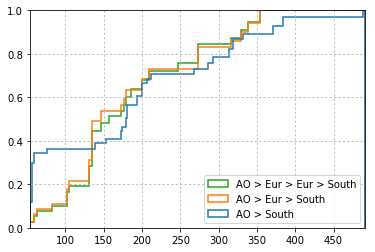

In [36]:
from matplotlib import pyplot as plt
%matplotlib inline

ao_s = [l for sublist in get_property('rtt', _h, dest=['Southern 1'], orig=['AO']) for l in sublist]

ao_e1 = [l for sublist in get_property('rtt', _h, dest=['Europe 1'], orig=['AO']) for l in sublist]
e1_s2 = [l for sublist in get_property('rtt', _h, dest=['Southern 2'], orig=['Europe 1']) for l in sublist]

e2_s3 = [l for sublist in get_property('rtt', _h, dest=['Southern 3'], orig=['Europe 2']) for l in sublist]


plt.hist(
    [ao_s, ao_e1+e1_s2, ao_e1+e1_s2+e2_s3,],
    bins=200,
    cumulative=True,
    normed=True,
    histtype='step',
    linewidth=1.5,
    label=['AO > South', 'AO > Eur > South', 'AO > Eur > Eur > South']
)

plt.legend(loc='lower right')
plt.margins(.0)
plt.grid(linestyle='dotted')
plt.show()

## Western cluster

In [37]:
from collections import defaultdict

cluster_to_countries = defaultdict(list)

for cc, clus in cluster_speed.iteritems():
    cluster_to_countries[clus].append(cc)

In [38]:
cluster = 'Southern'

In [39]:
trs_western = [tr for tr in trs_speed if 
               tr['country_origin'] in cluster_to_countries[cluster_name_2_number(cluster)] and
               tr['country_destination'] in cluster_to_countries[cluster_name_2_number(cluster)]
              ]

In [40]:
from collections import Counter

w = nx.DiGraph()

hops = []
ccs_h = []
for tr in trs_western:
    cc_list = []
    cc_o = tr['country_origin']
    for h in tr['hops']:
        
        cc_d = h['country_destination']
        cc_list.append(cc_d)
        
        if (cc_o, cc_d) not in w.edges():
            w.add_edge(cc_o, cc_d, weight=1, rtt=[h['min_rtt']])
        else:
            w[cc_o][cc_d]['weight'] += 1
            w[cc_o][cc_d]['rtt'].append(h['min_rtt'])
        cc_o = cc_d
    hops.append(cc_list)
    ccs_h += cc_list
if 'XX' in w.nodes():
    w.remove_node('XX')

In [41]:
w_clus = nx.DiGraph()

for e in w.edges():
    cc_o = e[0]
    cc_d = e[1]
    weight = w[cc_o][cc_d]['weight']
    rtt = w[cc_o][cc_d]['rtt']
    try:
        clus_o = cluster_names_speed[cluster_speed[e[0]]]
        clus_d = cluster_names_speed[cluster_speed[e[1]]]
        if (clus_o, clus_d) not in w_clus.edges():
            w_clus.add_edge(clus_o, clus_d, weight=weight, rtt=rtt)
        else:
            w_clus[clus_o][clus_d]['weight'] += weight
            w_clus[clus_o][clus_d]['rtt'] += rtt
    except KeyError as ke:
        continue

In [42]:
N = sum([w_clus[e[0]][e[1]]['weight'] for e in w_clus.edges()])

_sum = 0.0
for e in w_clus.edges():
    perc = w_clus[e[0]][e[1]]['weight']*1.0/N
    median = np.median([r for r in w_clus[e[0]][e[1]]['rtt'] if float(r) > 0.0])
    print "['%s', '%s', %.1f ms, %.1f%%, %.1f]," % (e[0], e[1], median, 100.0*perc, median*perc)
    
    if np.isnan(median*perc):
        continue
    _sum += median*perc
print _sum

['Europe', 'Europe', 23.0 ms, 11.0%, 2.5],
['Europe', 'N. America', 233.0 ms, 0.1%, 0.1],
['Europe', 'Southern', 6.0 ms, 5.4%, 0.3],
['Eastern', 'Europe', 181.0 ms, 0.1%, 0.3],
['Eastern', 'Southern', 113.0 ms, 0.3%, 0.3],
['Eastern', 'Western', 200.5 ms, 0.1%, 0.2],
['Eastern', 'Eastern', nan ms, 0.0%, nan],
['N. America', 'Europe', nan ms, 0.1%, nan],
['N. America', 'N. America', 77.0 ms, 0.2%, 0.1],
['N. America', 'Southern', 33.0 ms, 0.1%, 0.0],
['Southern', 'Europe', 23.0 ms, 5.3%, 1.2],
['Southern', 'Eastern', 203.0 ms, 0.4%, 0.8],
['Southern', 'N. America', 74.0 ms, 0.1%, 0.1],
['Southern', 'Southern', 36.0 ms, 76.5%, 27.5],
['Southern', 'Asia', 6.0 ms, 0.0%, 0.0],
['Southern', 'Western', 294.0 ms, 0.1%, 0.4],
['Western', 'Southern', 102.0 ms, 0.1%, 0.1],
['Western', 'Eastern', 217.0 ms, 0.1%, 0.3],
34.3676917236


In [43]:
w_sim = w_clus.copy()
# w_sim['Europe']['Southern']['rtt'] = [107]
# w_sim['Europe']['Western']['rtt'] = [24]
# w_sim['Western']['Europe']['rtt'] = [24]
# w_sim.remove_edges_from([
#     ('Europe', 'Europe')
# ])

w_sim.remove_nodes_from([
    'Europe', 'N. America', 'Asia'
])

N = sum([w_sim[e[0]][e[1]]['weight'] for e in w_sim.edges()])
_sum2 = 0
for e in w_sim.edges():
    perc = w_sim[e[0]][e[1]]['weight']*1.0/N
    median = np.median(w_sim[e[0]][e[1]]['rtt'])
    print "['%s', '%s', %.1f ms, %.1f%%, %.1f]," % (e[0], e[1], median, 100.0*perc, median*perc)
    
    if np.isnan(median*perc) or median == .0:
        continue
    _sum2 += median*perc
print _sum2

['Eastern', 'Southern', 20.0 ms, 0.4%, 0.1],
['Eastern', 'Western', 200.5 ms, 0.1%, 0.3],
['Eastern', 'Eastern', 0.0 ms, 0.0%, 0.0],
['Southern', 'Eastern', 203.0 ms, 0.5%, 1.0],
['Southern', 'Southern', 13.0 ms, 98.5%, 12.8],
['Southern', 'Western', 294.0 ms, 0.2%, 0.5],
['Western', 'Southern', 102.0 ms, 0.1%, 0.1],
['Western', 'Eastern', 217.0 ms, 0.2%, 0.4],
15.208424998


In [44]:
ms = 45
percentage = .14
mts = percentage * ms*.001 * 1E8
print mts

630000.0


In [45]:
(mts / (_sum*.001)) / 3E8

0.061103900049157965

In [46]:
(mts / (_sum2*.001)) / 3E8

0.13808135952810835

In [47]:
print 100.0*sum(
    get_weight(g, dest=['Overseas 1'], orig=['Africa 0']) +
    get_weight(g, dest=['Overseas 2'], orig=['Africa 1']) +
    get_weight(g, dest=['Overseas 3'], orig=['Africa 2']) +
    get_weight(g, dest=['Overseas 4'], orig=['Africa 3'])
) / sum([g[o][d]['weight'] for o,d in g.edges()])

28.2666383611


In [48]:
print 100.0*sum(
    get_weight(g, orig=['Overseas 1'], dest=['Overseas 2']) +
    get_weight(g, orig=['Overseas 2'], dest=['Overseas 3']) +
    get_weight(g, orig=['Overseas 3'], dest=['Overseas 4']) +
    get_weight(g, orig=['Overseas 4'], dest=['Overseas 5'])
) / sum([g[o][d]['weight'] for o,d in g.edges()])

12.3053361032


In [49]:
print 100.0*sum(
    get_weight(g, orig=['Europe 1'], dest=['N. America 2']) + 
    get_weight(g, orig=['N. America 1'], dest=['Europe 2']) +
    get_weight(g, orig=['Europe 2'], dest=['N. America 3']) + 
    get_weight(g, orig=['N. America 2'], dest=['Europe 3']) + 
    get_weight(g, orig=['Europe 3'], dest=['N. America 4']) + 
    get_weight(g, orig=['N. America 3'], dest=['Europe 4']) +
    get_weight(g, orig=['Europe 4'], dest=['N. America 5']) + 
    get_weight(g, orig=['N. America 4'], dest=['Europe 5'])
) / sum([g[o][d]['weight'] for o,d in g.edges()])

3.62867150894


In [50]:
100.0*sum(get_weight(g, dest=['Overseas 1'])) / sum(get_weight(g, orig=['Africa 0']))

50.40912472105133

### Western to all Africa

In [494]:
import networkx as nx

trs_western = [tr for tr in trs_speed if 
               tr['country_origin'] in ccs_from_clus('Western')
              ]

xticklabels = {
    0 : "Western",
    1 : "Eastern",
    2 : "Northern",
    3 : "Southern"
}
# xticklabels[0] = 'W'
# xticklabels[1] = 'E'
# xticklabels[2] = 'N'
# xticklabels[3] = 'S'
xticklabels[5] = 'S. America'
xticklabels[6] = 'N. America'
xticklabels[7] = 'Europe'
xticklabels[8] = 'Arabia'
xticklabels[9] = 'Asia'

w_all = nx.DiGraph()

countries = []
for tr in trs_western[:]:
    previous_hop = tr['as_origin']
    
    cc_o = tr['country_origin']
    if cc_o in ignored: continue
        
    clus_o = str(xticklabels[cluster_speed[cc_o]]) + " %d" % 0
    cc_o_key = "%s %d" % (cc_o, 0)
    
    i = 0
    for h in (tr['hops']):
        try:
            current_hop = h['as_destination']

            if current_hop == previous_hop:
                continue

            i += 1
            cc_d = h['country_destination']
            if cc_d == 'XX' or cc_d == 'LB' or cc_d == 'GP' or cc_d == 'SE':
                clus_d = 'Clus. XX'
            else:
                clus_d = str(xticklabels[cluster_speed[cc_d]]) + " %d" % i

            rtt = h['min_rtt']
            if (clus_o, clus_d) not in w_all.edges():
                w_all.add_edge(clus_o, clus_d, weight=1, rtt=[rtt])
            else:
                w_all[clus_o][clus_d]['weight'] += 1
                w_all[clus_o][clus_d]['rtt'].append(rtt)
                
        except KeyError as ke:
            print ke, get_name_from_cc(cc_d)
#             break
        finally:
            clus_o = clus_d
            cc_o = cc_d
            cc_o_key = cc_d_key
            previous_hop = current_hop

w_all.remove_node('Clus. XX')

u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda
u'RW' Rwanda


In [504]:
print sum(get_weight(w_all, orig=['Western 0']))
print sum(get_weight(w_all, orig=['Western 0'], dest=['Western 1']))
print sum(get_weight(w_all, orig=['Western 1'], dest=['Overseas 2']))

5097
842
161


### Latency

In [51]:
rtts1 = get_latency(g, dest=['Overseas 1'], orig=['Africa 0'])
rtts2 = get_latency(g, dest=['Africa 1'], orig=['Africa 0'])

print np.median(rtts1), np.median(rtts2)

69.0 27.0


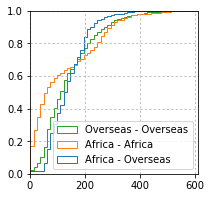

In [52]:
from matplotlib import pyplot as plt

rtts1 = get_latency(
    g,
    dest=['Overseas 2', 'Overseas 3', 'Overseas 4', 'Overseas 5'],
    orig=['Overseas 1', 'Overseas 2', 'Overseas 3', 'Overseas 4']
)

rtts2 = get_latency(
    g,
    dest=['Africa 1', 'Africa 2', 'Africa 3', 'Africa 4'],
    orig=['Africa 0', 'Africa 1', 'Africa 2', 'Africa 3']
)

rtts3 = get_latency(
    g,
    dest=['Overseas 1', 'Overseas 2', 'Overseas 3', 'Overseas 4'],
    orig=['Africa 0', 'Africa 1', 'Africa 2', 'Africa 3']
)

plt.figure(figsize=(3,3))

plt.hist(
    [
        [rtt for rtt in rtts1 if rtt != 0],
        [rtt for rtt in rtts2 if rtt != 0],
        [rtt for rtt in rtts3 if rtt != 0]
    ],
    normed=True,
    cumulative=True,
    histtype='step',
    bins=50
)

plt.legend(
    ['Overseas - Overseas', 'Africa - Africa', 'Africa - Overseas'],
    loc='lower right'
)
plt.margins(.0)
plt.grid(linestyle='dotted')
plt.show()

In [53]:
from collections import Counter
from operator import itemgetter

MIN = 15

banned = []
destinations = []
for cc, D in hops_origin.iteritems():
    destinations += D.keys()
    if len(D) <= MIN:
        banned.append(cc)
ctr = Counter(destinations)
banned += [cc for cc, count in ctr.items() if count <= MIN]

print banned

[u'BI', u'GN', u'YT', u'RW', u'NE', u'TG', u'CI', u'SZ', u'MG', u'SN', u'SD']


 Preparing Data (1/2) 100.0%
Painting matrix (2/2)


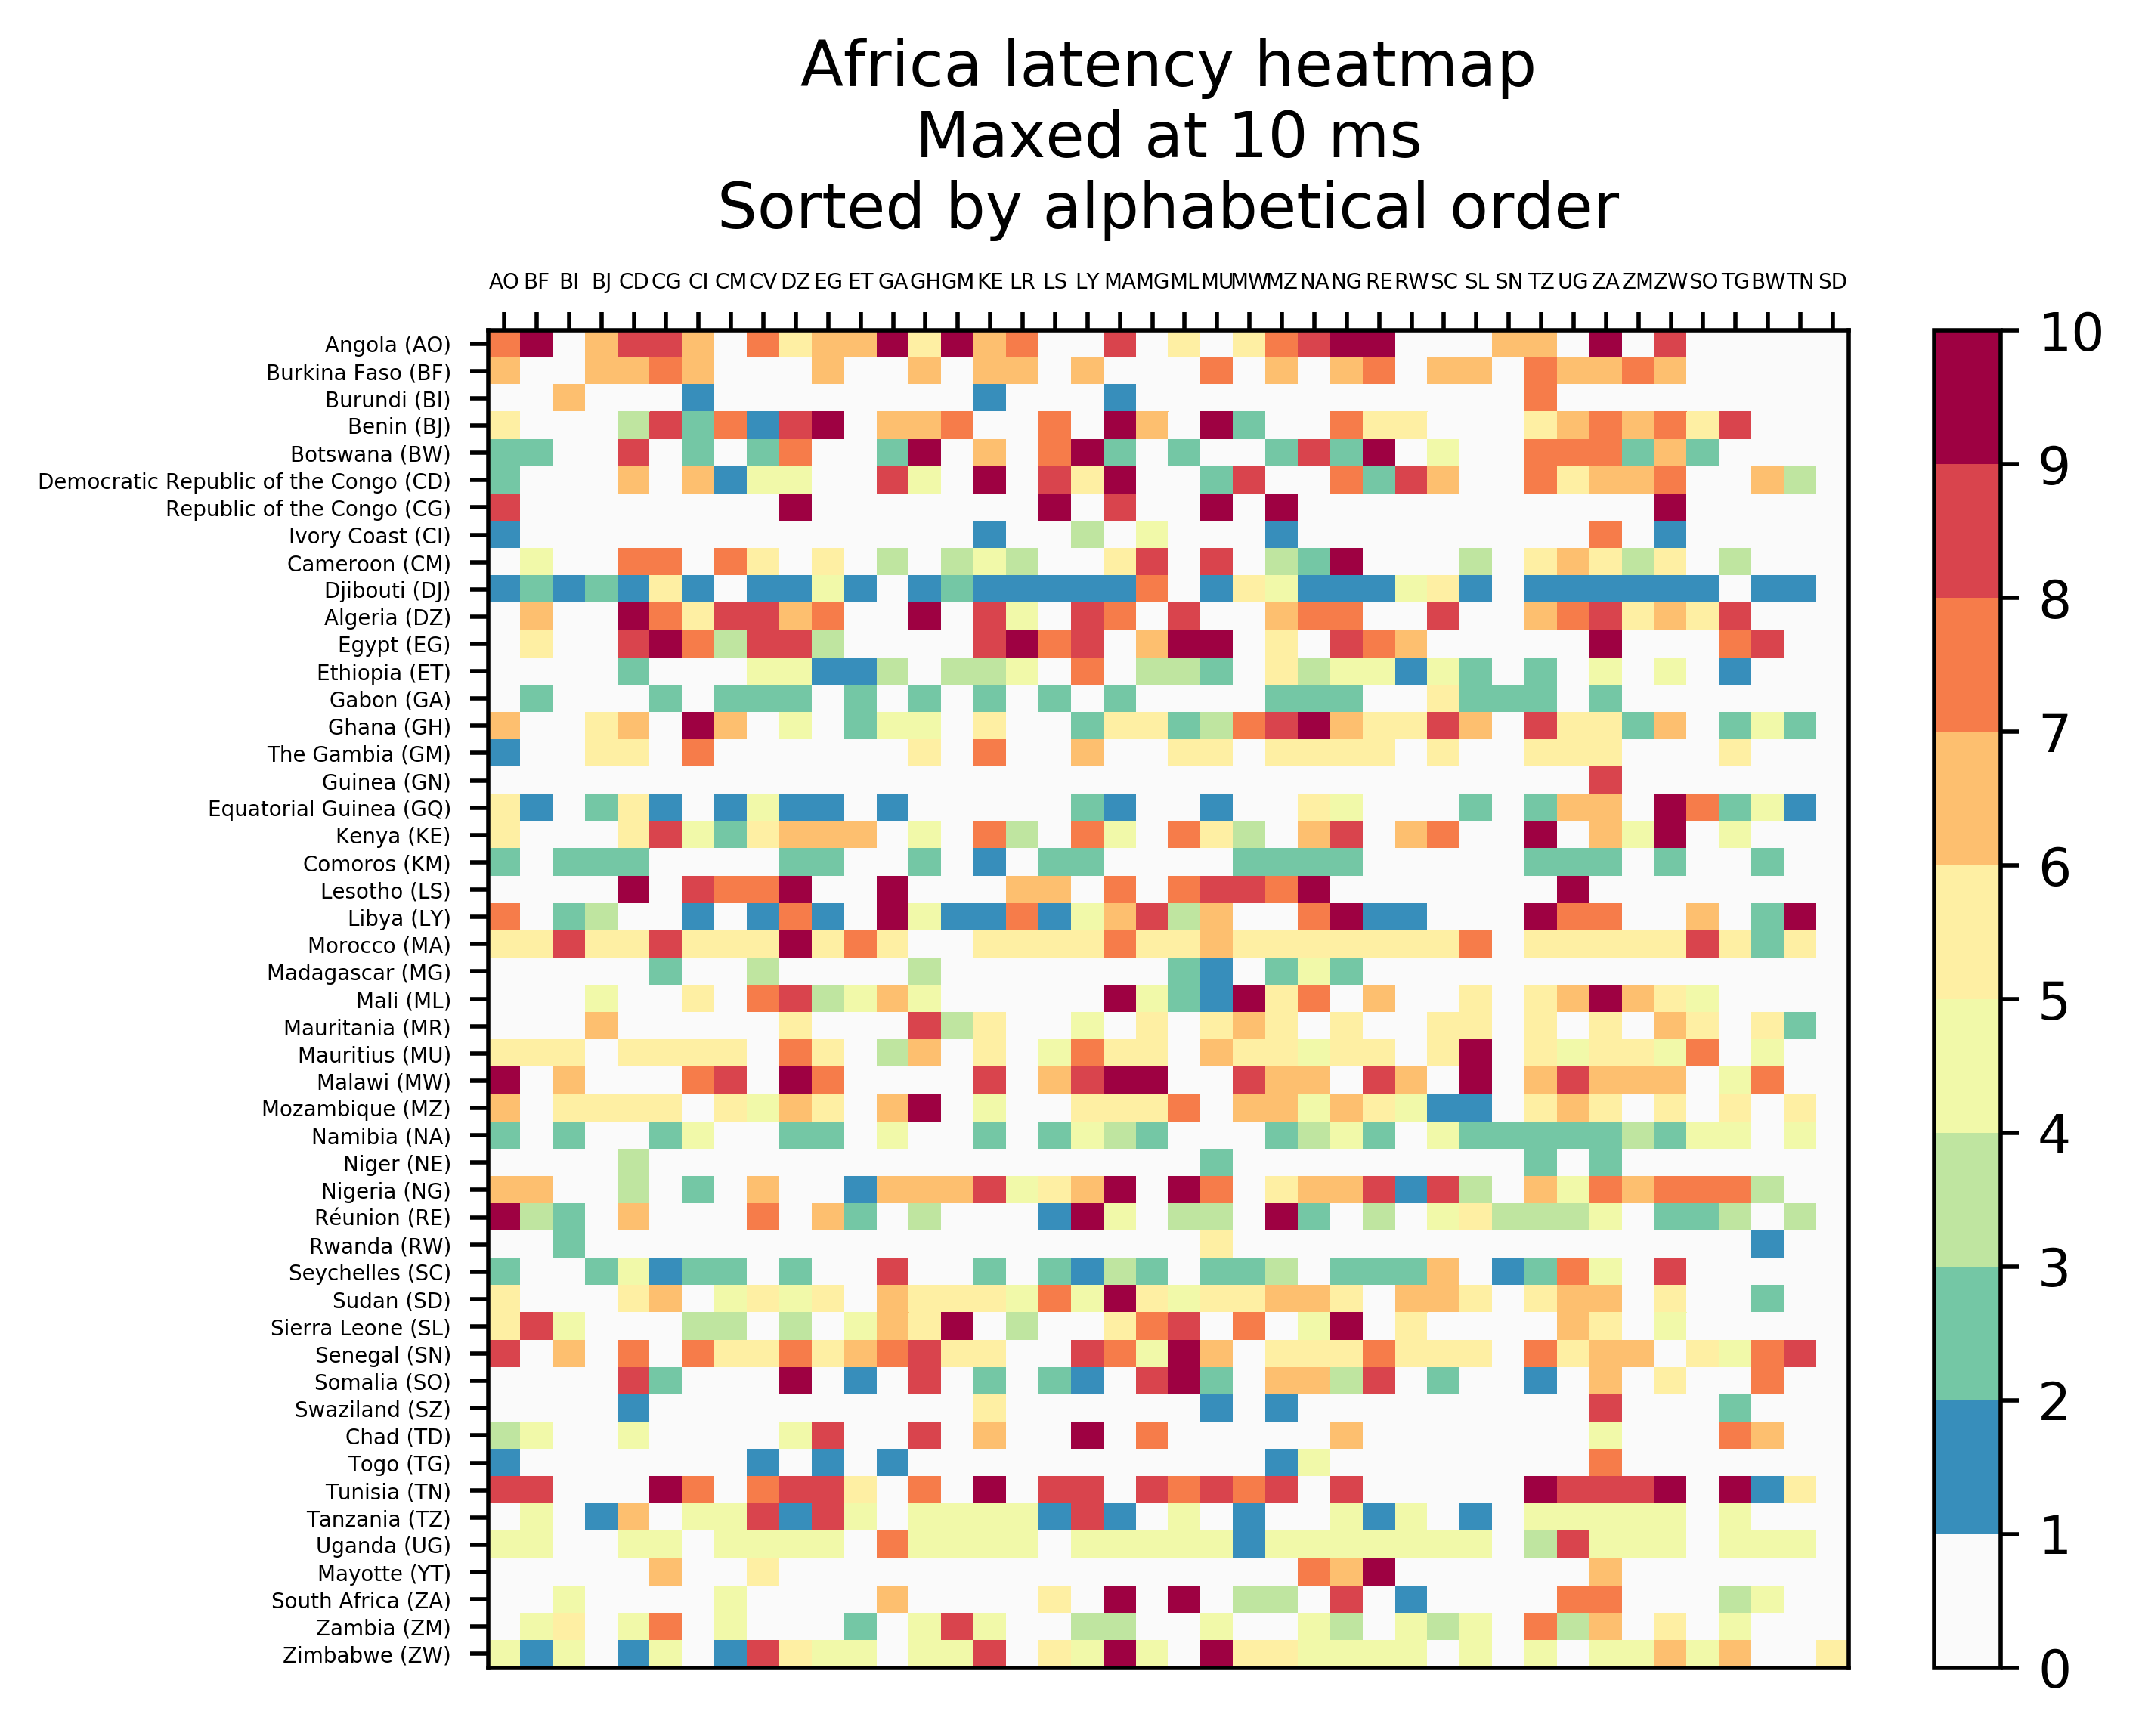

In [69]:
from matplotlib import pyplot as plt

Commons.build_heatmap(
    hops,
    filename="figs/hops",
    _min=0,
    _max=10,
    _ticks=1,
    plot_text=False,
    banned=banned,
    cmap=plt.get_cmap('Spectral_r'),
    figsize=(6,4),
    fontsize=4
)

In [536]:
import numpy as np

hops_to_region = defaultdict(float)

for o, D in hops.iteritems():
    to_region = []
    for d, h_count in D.iteritems():
        
        if o == d: continue
            
        to_region.append(h_count)
    hops_to_region[o] = np.median(to_region)

In [537]:
str(hops_to_region)

print np.median(hops_to_region.values()), np.average(hops_to_region.values())

5.0 5.21428571429


In [538]:
import numpy as np

hops_from_region_tmp = defaultdict(list)

for o, D in hops.iteritems():
    for d, h_count in D.iteritems():
        
        if o == d: continue
            
        hops_from_region_tmp[d].append(h_count)

In [539]:
hops_from_region = defaultdict(float)

for cc, h_list in hops_from_region_tmp.iteritems():
    hops_from_region[cc] = np.median(h_list)

print hops_from_region

defaultdict(<type 'float'>, {u'BF': 4.0, u'BI': 5.0, u'BJ': 5.0, u'BW': 4.0, u'DZ': 6.0, u'RW': 5.0, u'TZ': 5.5, u'NA': 6.0, u'NG': 6.0, u'TN': 4.0, u'RE': 7.0, u'LR': 4.0, u'LS': 6.0, u'TG': 4.0, u'LY': 6.0, u'ZM': 6.0, u'CI': 5.0, u'CM': 4.0, u'EG': 5.0, u'CG': 7.0, u'ZA': 6.0, u'AO': 5.0, u'CD': 5.0, u'GA': 6.5, u'ET': 4.0, u'GM': 7.5, u'ZW': 6.0, u'CV': 5.0, u'GH': 6.0, u'MG': 6.0, u'MA': 6.5, u'KE': 5.0, u'ML': 7.0, u'MU': 5.0, u'MW': 5.5, u'SO': 5.0, u'SN': 12.0, u'SL': 5.0, u'SC': 6.5, u'UG': 6.0, u'MZ': 5.0, u'SD': 5.0})


In [540]:
hops_asymmetry = defaultdict(float)

for o, hops_from in hops_from_region.iteritems():
    try:
        hops_to = hops_to_region[o]
        
        hops_asymmetry[o] = hops_to - hops_from
    except KeyError as ke:
        print ke, o

# On a cluster basis

In [542]:
hops_cluster_to_region = defaultdict(list)

for cc, h in hops_to_region.iteritems():
    try:
        clus = cluster_speed[cc]
        hops_cluster_to_region[clus].append(h)
    except KeyError as ke:
        print cc
        continue
print hops_cluster_to_region

GN
YT
RW
GQ
NE
RE
MR
CG
CV
SZ
KM
defaultdict(<type 'list'>, {0: [6.0, 1.0, 6.0, 1.0, 7.0, 1.0, 5.0, 8.0, 6.0, 2.0, 3.0, 5.0, 5.0, 6.0, 5.25], 1: [1.0, 4.0, 6.0, 5.0, 4.0], 2: [7.0, 8.0, 8.0, 0.0, 7.0, 9.0, 3.0, 5.0, 6.0, 6.0, 2.0, 5.0], 3: [6.0, 2.0, 10.0, 4.0, 10.0, 4.0, 8.0, 5.0]})


In [547]:
hops_cluster_to_region = defaultdict(list)
hops_cluster_from_region = defaultdict(list)
hops_intra_cluster = defaultdict(list)

for r in trs_speed:
    cc_o = r['country_origin']
    cc_d = r['country_destination']
    try:
        clus_o = cluster_speed[cc_o]
        clus_d = cluster_speed[cc_d]
    except KeyError as ke:
        print cc_d,
        continue
    hops = len(r['hops'])
    if clus_o == clus_d and cc_o != cc_d:
        hops_intra_cluster[clus_o].append(hops)
    else:
        hops_cluster_to_region[clus_o].append(hops)
        hops_cluster_from_region[clus_d].append(hops)

CG ZA RE RE RE ZA ZA ZA ZA NG NG ZA ZA ZA RE CV ZW TZ ZA ZA TZ RE RE RE RE CG BI ZW ZW CM CM CM CM LY LY CV RW ZW RE CG CG CG RW NG NG RE ZA ZA RE ZA CG CG CG CG CG MU RE MG MG ZA NA SC ZA ZA RE DZ RW NG NG RW CG RW CG ZA RW RW RE RE RE RE ZA CV RW RW ZA ZA LY NG CG GA GA RE RE RE ZA MA RE ZM ZA NG NG RW SO RW RW RE CG CG CG CG CV RE RE RE ZA RE RE RE RE RE UG UG RE CG SO SO NG RE NA CG ZA ZA CG CG RE RE RE RE ZA CG CV CV CG RE CV CG CG ZA ML CG MA MA NA RE RW CG AO AO MW AO RE RE RW ZA RE RW MZ MZ CG CG RE CG CV RE RE CG RE ZA KE ZA CG CG ZA CG CG RE RE RE RE ZA CG CG RE RE RE RE CI CI CI ZA ZA ZA RE RE RE RE RE RE ZA RE RE RE RE RE RE RE GA GA GA ZA ZA CG CG CG UG CV CG RW RW MG ZA ZA RE RE CD CG DZ DZ DZ KE KE ZA ZA ZA RW RE RE RE RE RE RE RE RE CG CG CG CG CG NG RE RE RE NA ZA NG RE ZM RE CG UG UG ZA GM GM ZA CG RE ZA AO AO MU ZA ZA CG CG RE RE GH ZA CG ZA ZA CG RW UG RW RW RE RE RE RE ZM ZM RW RW ZA ZA RE ZA BI RE RE UG CV ZA CV TZ BW BW RE RE MU CD RW RW RW CV CG ZA CG RE TZ TZ Z

In [549]:
hops_cluster = defaultdict(lambda: defaultdict(list))

for cc_o, D in hops_origin.iteritems():
    for cc_d, hops in D.iteritems():
        try:
            clus_o = cluster_speed[cc_o]
            clus_d = cluster_speed[cc_d]
        except KeyError as ke:
            print cc,
            continue
        hops_cluster[clus_o][clus_d] += hops

MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ


In [550]:
hops_cluster_interdomain = defaultdict(lambda: defaultdict(list))

for cc_o, D in hops_origin_interdomain.iteritems():
    for cc_d, hops in D.iteritems():
        try:
            clus_o = cluster_speed[cc_o]
            clus_d = cluster_speed[cc_d]
        except KeyError as ke:
            print cc,
            continue
        hops_cluster_interdomain[clus_o][clus_d] += hops

MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ


In [551]:
hops_cluster_overseas = defaultdict(lambda: defaultdict(list))

for cc_o, D in hops_origin_overseas.iteritems():
    for cc_d, hops in D.iteritems():
        try:
            clus_o = Commons.cluster_speed[cc_o]
            clus_d = Commons.cluster_speed[cc_d]
        except KeyError as ke:
            print cc,
            continue
        in_ccs = len([h for h in hops if h])
        not_in_ccs = len([h for h in hops if not h])
        
        if in_ccs + not_in_ccs == 0:
            continue
            
        ratio = 1.0*not_in_ccs / (in_ccs + not_in_ccs)
        hops_cluster_overseas[clus_o][clus_d].append(ratio)

MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ MZ M

In [552]:
hops_cluster_median = defaultdict(lambda: defaultdict(float))
for clus_o, D in hops_cluster.iteritems():
    for clus_d, hops in D.iteritems():
        hops_cluster_median[clus_o][clus_d] = np.median(hops)

In [553]:
hops_cluster_interdomain_median = defaultdict(lambda: defaultdict(float))
for clus_o, D in hops_cluster_interdomain.iteritems():
    for clus_d, hops in D.iteritems():
        hops_cluster_interdomain_median[clus_o][clus_d] = np.median(hops)

In [554]:
hops_cluster_overseas_median = defaultdict(lambda: defaultdict(float))
for clus_o, D in hops_cluster_overseas.iteritems():
    for clus_d, hops in D.iteritems():
        hops_cluster_overseas_median[clus_o][clus_d] = 100*np.median(hops)

In [555]:
hops_first_interdomain_hop_median = defaultdict(lambda: defaultdict(float))
for clus_o, D in hops_first_interdomain_hop.iteritems():
    for clus_d, hops in D.iteritems():
        hops_first_interdomain_hop_median[clus_o][clus_d] = np.median(hops)

 Preparing Data (1/2) 100.0%
Painting matrix (2/2)


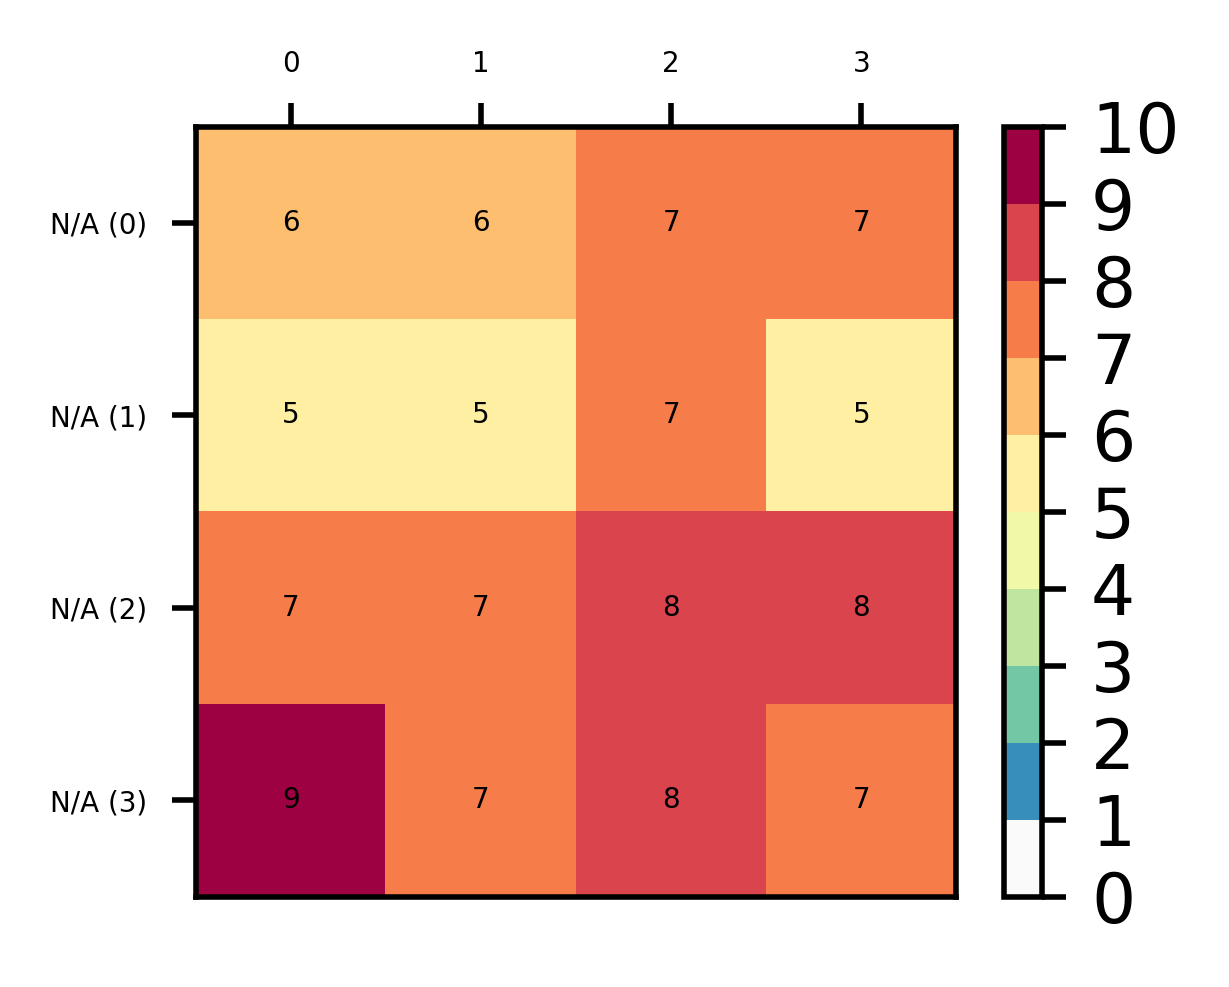

Count of inter-domain hops
 Preparing Data (1/2) 100.0%
Painting matrix (2/2)


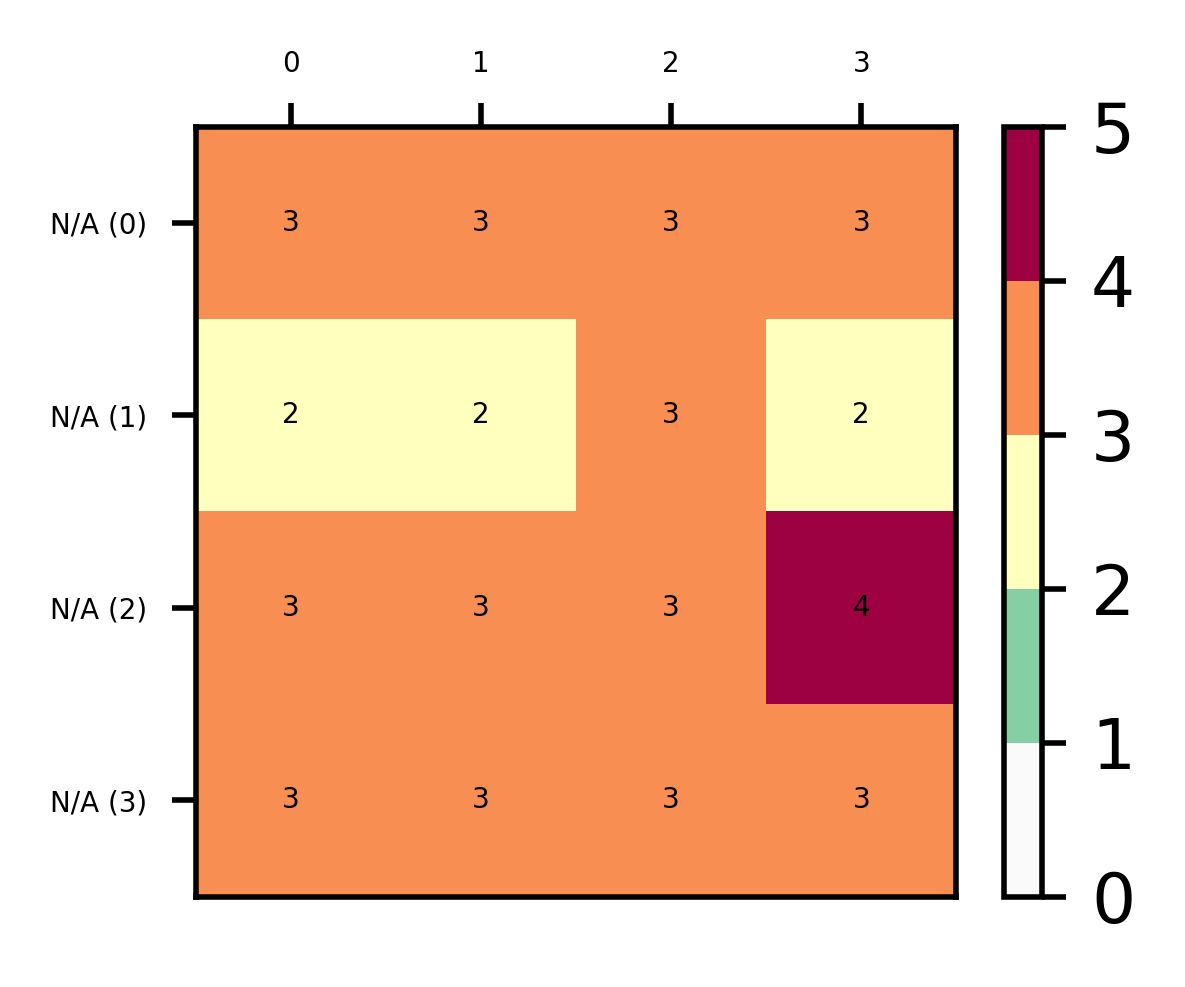

In [734]:
from matplotlib import pyplot as plt

for matrix in [hops_cluster_median, hops_cluster_interdomain_median, hops_cluster_overseas_median, hops_first_interdomain_hop_median]:
    if 4 in matrix.keys(): del matrix[4]
    for i in [0,1,2,3]:
        if 4 in matrix[i].keys(): del matrix[i][4]

Commons.build_heatmap(
    hops_cluster_median,
    filename="figs/hops_clusters",
    title="\n",
    _min=0,
    _max=10,
    _ticks=1,
    plot_text=True,
#     banned=banned,
    cmap=plt.get_cmap('Spectral_r'),
    figsize=(2.5,2),
    fontsize=4,
)
plt.show()

print "Count of inter-domain hops"
Commons.build_heatmap(
    hops_cluster_interdomain_median,
    filename="figs/hops_clusters_interdomain",
    title="\n",
    _min=0,
    _max=5,
    _ticks=1,
    plot_text=True,
#     banned=banned,
    cmap=plt.get_cmap('Spectral_r'),
    figsize=(2.5,2),
    fontsize=4,
)
plt.show()

 Preparing Data (1/2) 100.0%
Painting matrix (2/2)


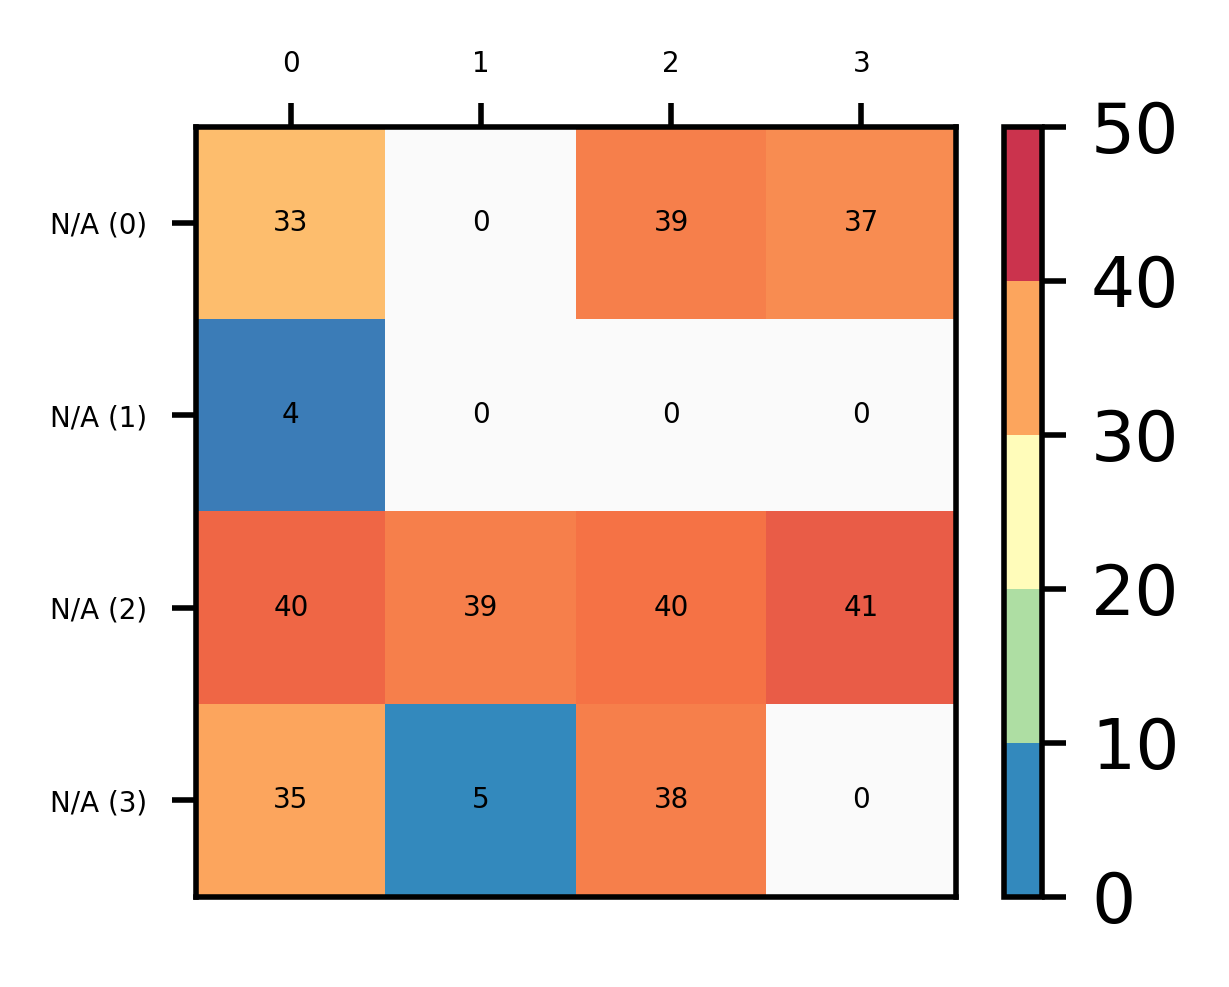

In [557]:
Commons.build_heatmap(
    hops_cluster_overseas_median,
    filename="figs/hops_clusters_overseas",
    title="\n",
    _min=0,
    _max=50,
    _ticks=10,
    plot_text=True,
#     banned=banned,
    cmap=plt.get_cmap('Spectral_r'),
    figsize=(2.5,2),
    fontsize=4,
)
plt.show()

First interdomain hop (plotting min rtt)
 Preparing Data (1/2) 100.0%
Painting matrix (2/2)
['W', 'E', 'N', 'S', 'N. America', 'Europe', 'Asia', 'Arabia']


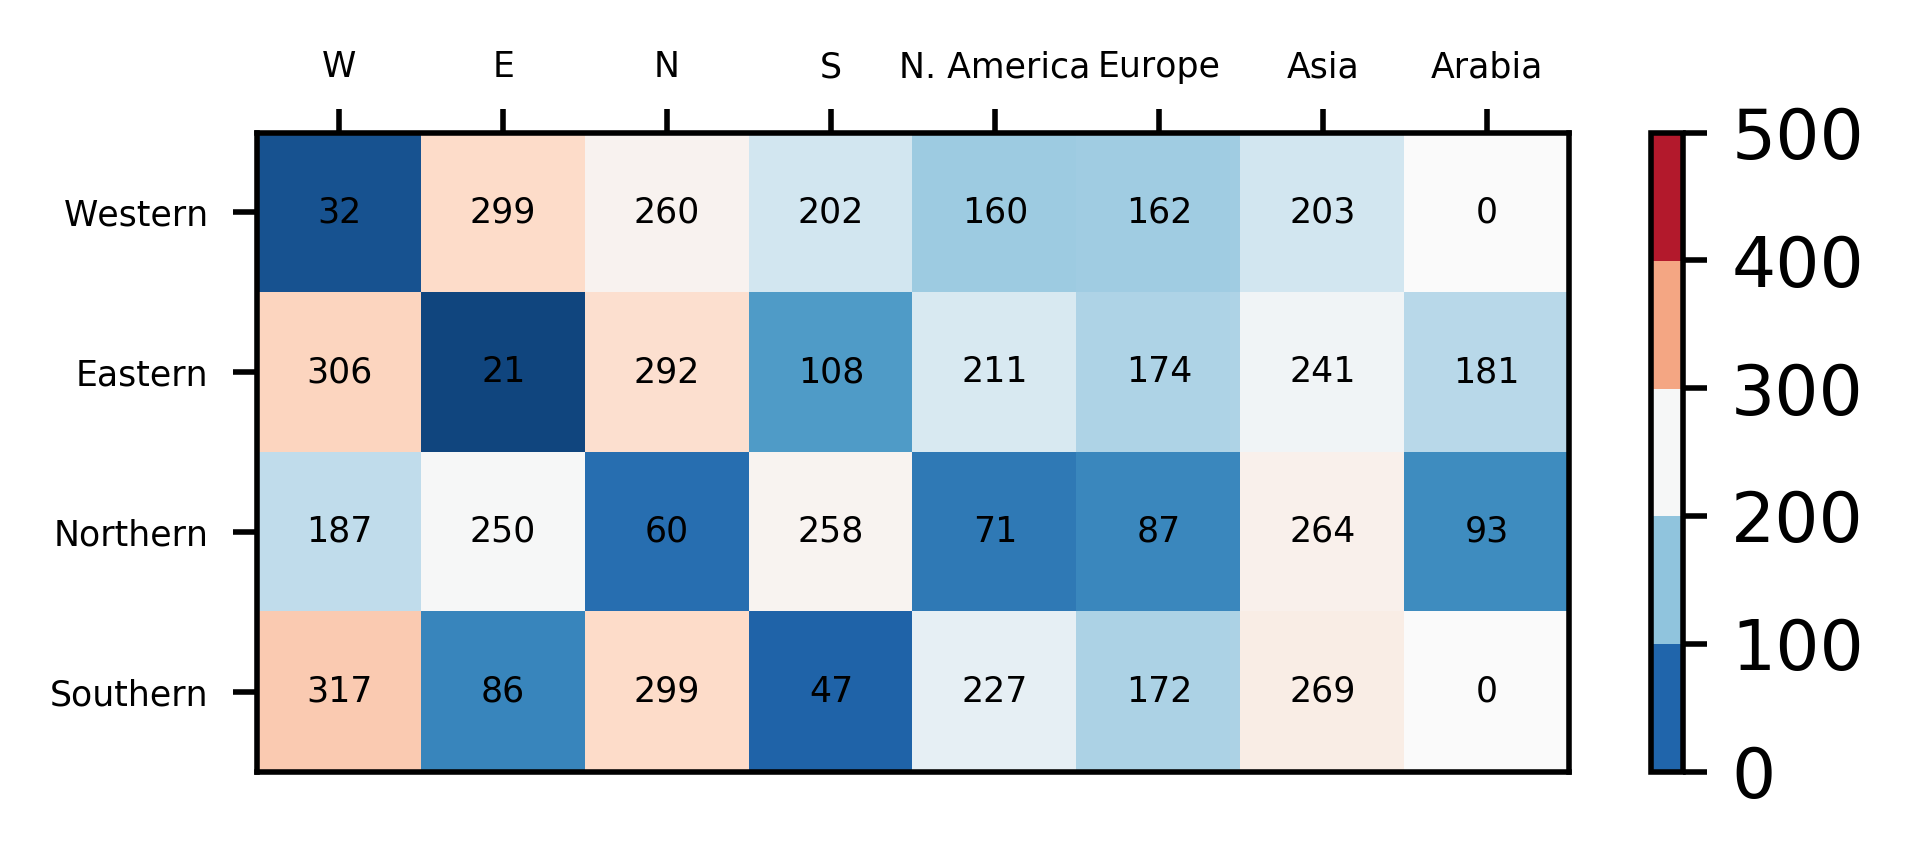

In [558]:
print "First interdomain hop (plotting min rtt)"

xticklabels[0] = 'W'
xticklabels[1] = 'E'
xticklabels[2] = 'N'
xticklabels[3] = 'S'

Commons.build_heatmap(
    hops_first_interdomain_hop_median,
    filename="figs/hops_first_interdomain_hop_min_rtt",
    title="\n",
    _min=0,
    _max=500,
    _ticks=100,
    plot_text=True,
#     banned=banned,
    cmap=plt.cm.RdBu_r,  # get_cmap('Spectral_r'),
    figsize=(4,1.75),
    fontsize=5,
    yticklabels=Commons.cluster_names_speed,
    xticklabels=xticklabels
)
plt.show()

In [559]:
over = []
for orig in [0,1,2,3]:
    for dest in [1,2,3]:
        rtt = hops_first_interdomain_hop_median[orig][dest]
        if rtt > 0:
            over.append(rtt)

# How big is this?

In [64]:
hops_first_interdomain_hop_count = defaultdict(lambda: defaultdict(float))
for clus_o, D in hops_first_interdomain_hop.iteritems():
    for clus_d, hops in D.iteritems():
        hops_first_interdomain_hop_count[clus_o][clus_d] = len(hops)
        if len(hops) > 1000:
            print xticklabels[clus_o], xticklabels[clus_d], len(hops), np.median(hops)

W Europe 1400 162.0
N N. America 1175 71.0
N Europe 3609 87.0
S S 1288 47.0


### Preparing for JS  Fiddle

In [65]:
xticklabels = Commons.cluster_names_speed.copy()
xticklabels[6] = 'N. America'
xticklabels[7] = 'Europe'
xticklabels[8] = 'Arabia'
xticklabels[9] = 'Asia'

for o, D in hops_first_interdomain_hop_count.iteritems():
    for d, count in D.iteritems():
#         if o == d: continue
            
        print "['%s', '%s ', %d]," % (xticklabels[o], xticklabels[d], count)

['Western', 'Western ', 512],
['Western', 'Eastern ', 120],
['Western', 'Northern ', 165],
['Western', 'Southern ', 633],
['Western', 'N. America ', 430],
['Western', 'Europe ', 1400],
['Western', 'Asia ', 29],
['Eastern', 'Western ', 96],
['Eastern', 'Eastern ', 906],
['Eastern', 'Northern ', 176],
['Eastern', 'Southern ', 281],
['Eastern', 'N. America ', 47],
['Eastern', 'Europe ', 176],
['Eastern', 'Arabia ', 9],
['Eastern', 'Asia ', 57],
['Northern', 'Western ', 371],
['Northern', 'Eastern ', 329],
['Northern', 'Northern ', 857],
['Northern', 'Southern ', 942],
['Northern', 'N. America ', 1175],
['Northern', 'Europe ', 3609],
['Northern', 'Arabia ', 234],
['Northern', 'Asia ', 112],
['Southern', 'Western ', 298],
['Southern', 'Eastern ', 229],
['Southern', 'Northern ', 110],
['Southern', 'Southern ', 1288],
['Southern', 'N. America ', 242],
['Southern', 'Europe ', 625],
['Southern', 'Asia ', 34],


First interdomain hop (plotting count)
 Preparing Data (1/2) 100.0%
Painting matrix (2/2)
['N', 'SE', 'SW', 'C', 'US', 'Europe', 'Arabia', 'Asia']


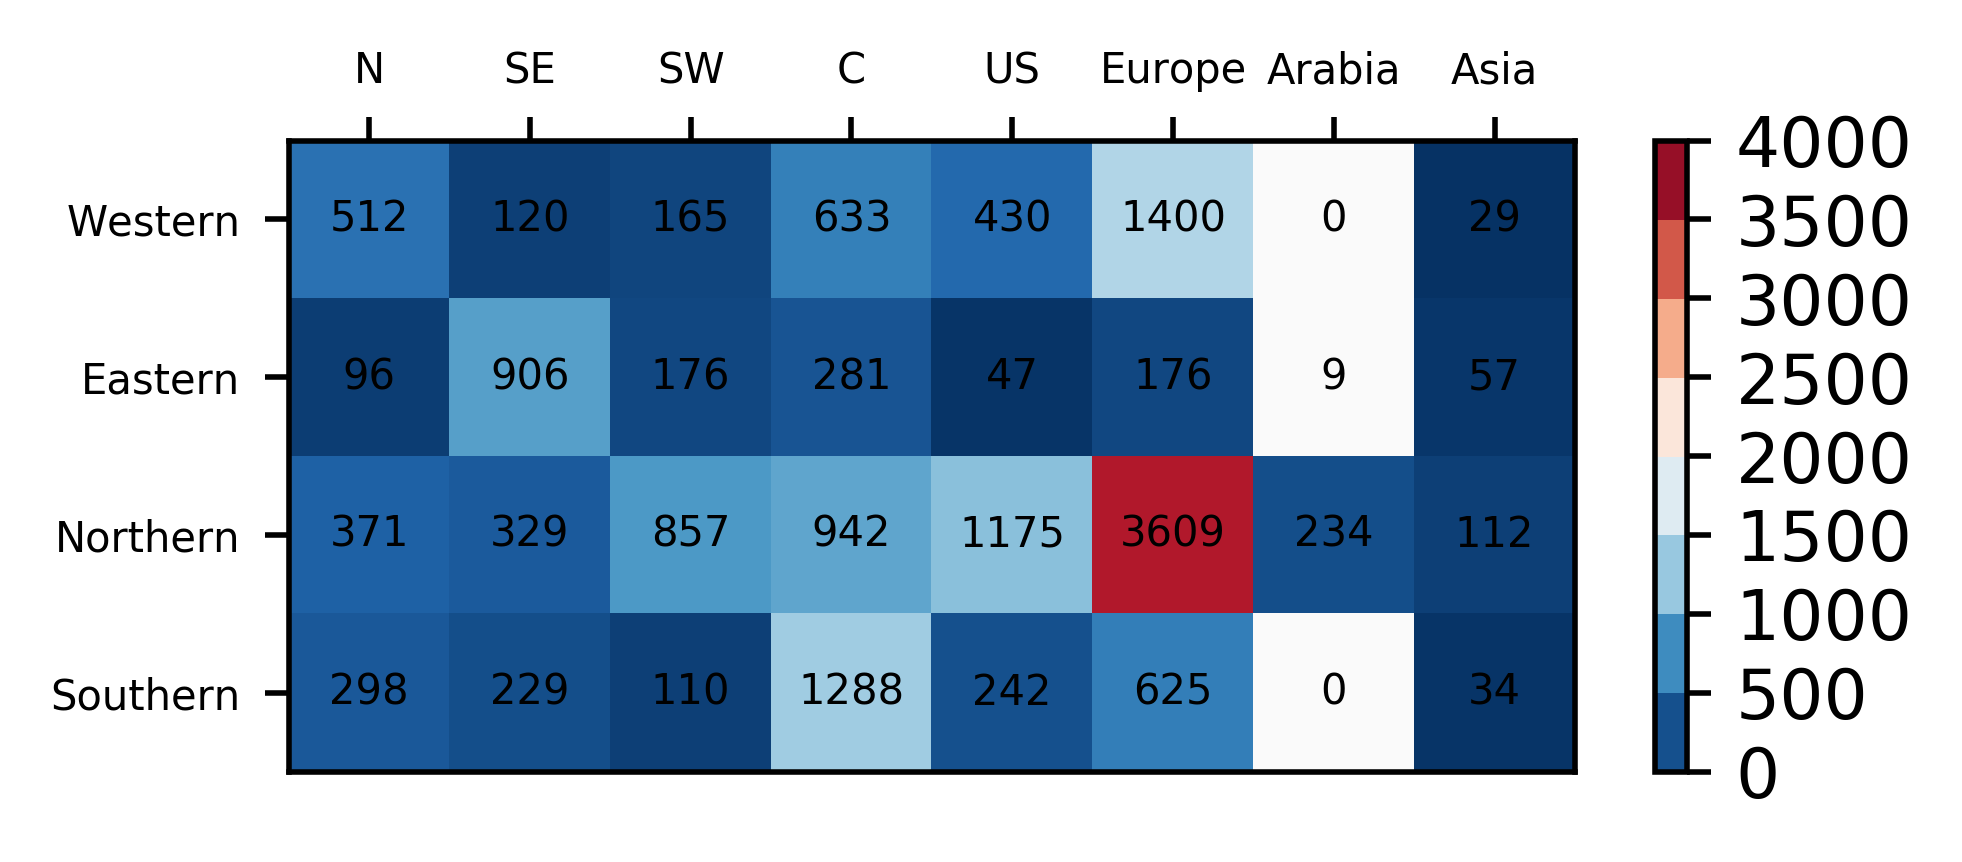

In [81]:
print "First interdomain hop (plotting count)"

for matrix in [hops_first_interdomain_hop_count]:
    if 4 in matrix.keys(): del matrix[4]
    for i in [0,1,2,3]:
        if 4 in matrix[i].keys(): del matrix[i][4]

xticklabels = Commons.cluster_names_speed.copy()
xticklabels[0] = 'N'
xticklabels[1] = 'SE'
xticklabels[2] = 'SW'
xticklabels[3] = 'C'
xticklabels[6] = 'US'
xticklabels[7] = 'Europe'
xticklabels[8] = 'Arabia'
xticklabels[9] = 'Asia'

Commons.build_heatmap(
    hops_first_interdomain_hop_count,
    filename="figs/hops_first_interdomain_hop_hop_count",
    title="\n",
    _min=0,
    _max=4000,
    _ticks=500,
    plot_text=True,
#     banned=banned,
    cmap=plt.cm.RdBu_r,
    figsize=(4,1.75),
    fontsize=6,
    yticklabels=Commons.cluster_names_speed,
    xticklabels=xticklabels
)
plt.show()

/Users/agustin/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


NameError: name 'hops_asymmetry' is not defined

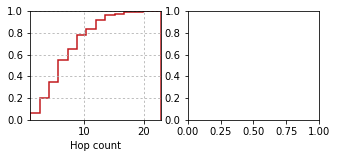

In [67]:
from matplotlib import gridspec

fig = plt.figure(1, figsize=(8,2))
# fig.suptitle(
#     "ECDF showing traceroute hop count information",
#     y=1.05
# )

gs = gridspec.GridSpec(1, 3)

# First
plt.subplot(gs[0])
plt.hist(
    [r['hop_count'] for r in trs_speed],
    histtype='step',
    linewidth=1.5,
    cumulative=True,
    normed=True,
    bins=14,
    color=[plt.cm.Reds(200)]
)
# plt.hist(
#     [hops_to_region.values(), hops_from_region.values()],
#     histtype='step',
#     linewidth=1.5,
#     cumulative=True,
#     normed=True,
#     bins=16,
#     color=[plt.cm.Reds(200), plt.cm.Blues(200)],
#     label=['Outgoing', 'Incoming']
# )
# plt.gca().get_xaxis().set_ticklabels([1,2,3,4,5,7,10])
# plt.gca().set_ylim([.4, 1])
plt.grid(linestyle='dotted')
plt.margins(0)
plt.legend(loc='lower right')
plt.xlabel("Hop count")

# Second
plt.subplot(gs[1])
plt.hist(
    [hops_asymmetry.values()],
    histtype='step',
    linewidth=1.5,
    cumulative=True,
    normed=True,
    bins=14,
    color=[plt.cm.Reds(200)]
)

# plt.gca().get_xaxis().set_ticklabels([-8, -4, 0, 4, 8])
plt.gca().set_xlim([-8, +8])

plt.xlabel("Hop count difference")
plt.grid(linestyle='dotted')
plt.margins(0)

# Third
plt.subplot(gs[2])
plt.hist(
    [abs(h) for h in hops_asymmetry.values()],
    histtype='step',
    linewidth=1.5,
    cumulative=True,
    normed=True,
    bins=14,
    color=[plt.cm.Reds(200)]
)

plt.gca().set_ylim([.4, 1])

plt.xlabel("Hop count difference \n (absolut values)")
plt.grid(linestyle='dotted')
plt.margins(0)




# Finally
plt.savefig('figs/hop_count.png', dpi=500, bbox_inches='tight')
plt.savefig('figs/hop_count.pdf', dpi=500, bbox_inches='tight')
plt.show()

## By cluster

In [607]:
cluster_colors = {
    0: '#00B1E2',
    1: '#A8C023',
    2: '#FF9D00',
    3: '#DB3B29',
    4: 'cyan',
    5:'grey',
    6:'grey',
    7:'grey',
    8:'grey',
    9:'grey'
}

ASes
Western 3.0
Eastern 2.0
Northern 3.0
Southern 3.0
Routers
Western 6.0
Eastern 5.0
Northern 8.0
Southern 7.0


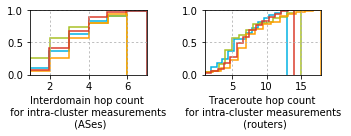

In [824]:
fig = plt.figure(1, figsize=(5,2))

gs = gridspec.GridSpec(1, 2)

# First
plt.subplot(gs[0])
print 'ASes'
for clus in [0,1,2,3]:
    l_flattened = hops_cluster_interdomain[clus][clus]
    
    
    print cluster_names_speed[clus], np.median(hops_cluster_interdomain[clus][clus])
    
    plt.hist(
        l_flattened,
        histtype='step',
        linewidth=1.5,
        cumulative=True,
        normed=True,
        bins=100,
        color=cluster_colors[clus],
        label=xticklabels[clus]
    )
plt.grid(linestyle='dotted')
plt.margins(0)
# plt.legend(loc='lower right')
plt.xlabel("Interdomain hop count \n for intra-cluster measurements \n (ASes)")

plt.subplot(gs[1])
print 'Routers'
for clus in [0,1,2,3]:
    plt.hist(
        hops_cluster[clus][clus],
        histtype='step',
        linewidth=1.5,
        cumulative=True,
        normed=True,
        bins=14,
        color=cluster_colors[clus],
        label=xticklabels[clus]
    )
    
    
    print cluster_names_speed[clus], np.median(hops_cluster[clus][clus])
    
plt.grid(linestyle='dotted')
plt.margins(0)
plt.xlabel("Traceroute hop count \n for intra-cluster measurements \n (routers)")
plt.tight_layout()
# plt.legend(loc='lower right')
plt.savefig('figs/cdf-traces-clusters.pdf', dpi=500, bbox_inches='tight')
plt.savefig('figs/cdf-traces-clusters.png', dpi=500, bbox_inches='tight')
plt.show()

## By country

In [785]:
hops_same_cc_plot = defaultdict(list)

for tr in trs_speed:
    if tr['country_origin'] != tr['country_destination']:
        continue
    cc = tr['country_origin']
    try:
        clus = cluster_speed[cc]
        hops_same_cc_plot[clus] += [tr['hop_count']]
    except:
        pass

In [812]:
hops_same_cc_interdomain_plot = defaultdict(list)

for cc, D in hops_origin_interdomain.iteritems():
    try:
#         print cc, cluster_speed[cc], hops_origin_interdomain[cc][cc]
        hops_same_cc_interdomain_plot[cluster_speed[cc]] += hops_origin_interdomain[cc][cc]
    except:
        continue

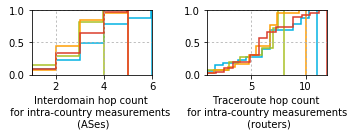

In [814]:
fig = plt.figure(1, figsize=(5,2))

gs = gridspec.GridSpec(1, 2)

# First
plt.subplot(gs[0])
for clus in [0,1,2,3]:
    l_flattened = hops_same_cc_interdomain_plot[clus]
    plt.hist(
        l_flattened,
        histtype='step',
        linewidth=1.5,
        cumulative=True,
        normed=True,
        bins=100,
        color=cluster_colors[clus],
        label=xticklabels[clus]
    )
plt.grid(linestyle='dotted')
plt.margins(0)
# plt.legend(loc='lower right')
plt.xlabel("Interdomain hop count \n for intra-country measurements  \n (ASes)")

plt.subplot(gs[1])
for clus in [0,1,2,3]:
    plt.hist(
        hops_same_cc_plot[clus],
        histtype='step',
        linewidth=1.5,
        cumulative=True,
        normed=True,
        bins=14,
        color=cluster_colors[clus],
        label=xticklabels[clus]
    )

plt.grid(linestyle='dotted')
plt.margins(0)
# plt.legend(loc='lower right')
plt.xlabel("Traceroute hop count \n for intra-country measurements \n (routers)")
plt.tight_layout()
plt.savefig('figs/cdf-traces-countries.pdf', dpi=500, bbox_inches='tight')
plt.savefig('figs/cdf-traces-countries.png', dpi=500, bbox_inches='tight')
plt.show()
plt.show()

## Correlate traceroute and RTT info

In [827]:
import json
import requests

j = requests.get('https://simon.lacnic.net/static/results-africa-connectivity.json').text
rs_speed = json.loads(j)

In [830]:
from collections import defaultdict

rtts_cluster_to_region = defaultdict(list)
rtts_cluster_from_region = defaultdict(list)
rtts_intra_cluster = defaultdict(list)
rtts_cluster = defaultdict(lambda: defaultdict(list))

for r in rs_speed:
    try:
        clus_o = Commons.cluster_speed[r['country_origin']]
        clus_d = Commons.cluster_speed[r['country_destination']]
        rtt = r['min_rtt']

        rtts_cluster[clus_o][clus_d].append(rtt)

        if clus_o == clus_d:
            rtts_intra_cluster[clus_o].append(rtt)
        else:
            rtts_cluster_to_region[clus_o].append(rtt)
            rtts_cluster_from_region[clus_d].append(rtt)
    except:
        continue

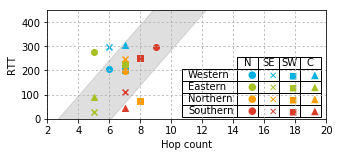

In [831]:
import numpy as np
from matplotlib import gridspec
from matplotlib import pyplot as plt
from __future__ import unicode_literals

fig = plt.figure(1, figsize=(5,2))

# gs = gridspec.GridSpec(1, 2)

cluster_shapes = {
    0:'o',
    1:'x',
    2:'s',
    3:'^'
}

# for hops_cluster_xaxis in [hops_cluster_median, hops_cluster_interdomain_median]:
# plt.subplot(gs[0])
x = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.fill_between(
    x,
    [73.39*i-450 for i in x], [73.39*i-200 for i in x],
    alpha=.25,
    color='grey'
)

for clus_o in [0,1,2,3]:
    for clus_d in [0,1,2,3]:
        y = np.median(rtts_cluster[clus_o][clus_d])
        x = hops_cluster_median[clus_o][clus_d]
        plt.scatter(
            x,
            y,
            c=cluster_colors[clus_o],
            marker=cluster_shapes[clus_d]
        )

plt.ylim(0,450)
plt.xlim(2, 20)
plt.grid(linestyle='dotted')
plt.margins(0)
plt.xlabel('Hop count')
plt.ylabel('RTT')
# plt.legend(loc='lower right')





# plt.subplot(gs[1])
# x = range(0,6)
# plt.fill_between(
#     x,
#     [100.0*i+50 for i in x], [100.0*i-310 for i in x],
#     alpha=.25,
#     color='grey'
# )

# for clus_o in [0,1,2,3]:
#     for clus_d in [0,1,2,3]:
#         y = np.median(rtts_cluster[clus_o][clus_d])
#         x = hops_cluster_interdomain_median[clus_o][clus_d]
#         plt.scatter(
#             x,
#             y,
#             c=cluster_colors[clus_o],
#             marker=cluster_shapes[clus_d]
#         )
        
# for clus_o in [0,1,2,3]:
#     for clus_d in [0,1,2,3]:
#         table._cells[(clus_o+1,clus_d)]._text.set_color(cluster_colors[clus_o])

# plt.ylim(0,450)
# plt.xlim(0,5)
# plt.grid(linestyle='dotted')
# plt.margins(0)
# plt.xticks([1,2,3,4,5])
# plt.xlabel('Interdomain count')
# plt.ylabel('RTT')
# plt.legend(loc='lower right')




# plt.subplot(gs[2])
table = plt.table(
    cellText=[
        ['●', '✕', '◼︎', '▲'],
        ['●', '✕', '◼︎', '▲'],
        ['●', '✕', '◼︎', '▲'],
        ['●', '✕', '◼︎', '▲']
    ],
    colWidths = [.075]*4,
    rowLabels=[Commons.cluster_names_speed[i] for i in [0,1,2,3]],
    colLabels=['N', 'SE', 'SW', 'C'],
    loc='lower right'
)
for clus_o in [0,1,2,3]:
    for clus_d in [0,1,2,3]:
        table._cells[(clus_o+1,clus_d)]._text.set_color(cluster_colors[clus_o])


plt.savefig('figs/scatter-traces-rtt-clusters.pdf', dpi=500, bbox_inches='tight')
plt.savefig('figs/scatter-traces-rtt-clusters.png', dpi=500, bbox_inches='tight')
plt.show()

In [832]:
from numpy import polyfit

xs = []
ys = []

for clus_o in [0,1,2,3]:
    for clus_d in [0,1,2,3]:
        
        if clus_o == 3 and clus_d in [0,1,2]:
            continue
            
        if clus_o == 2 and clus_d == 0:
            continue
            
        ys.append(np.median(rtts_cluster[clus_o][clus_d]))
        xs.append(hops_cluster_median[clus_o][clus_d])
polyfit(xs, ys, 1)

array([  12.19230769,  108.58333333])

## Upstreams

In [619]:
import networkx as nx

g_countries_upstreams = nx.DiGraph()

countries = []
for tr in trs_speed:
    previous_hop = tr['country_origin']
    
    cc_o = tr['country_origin']
    if cc_o in ignored: continue
    
    i = 0
    for h in (tr['hops']):
        try:
            current_hop = h['country_destination']

            if current_hop == previous_hop or current_hop in banned_ccs:
                previous_hop = current_hop
                continue

            i += 1
            cc_d = h['country_destination']
            rtt = h['min_rtt']

            if (cc_o, cc_d) not in g_countries_upstreams.edges():
                g_countries_upstreams.add_edge(cc_o, cc_d, weight=1, rtt=[rtt])
            else:
                g_countries_upstreams[cc_o][cc_d]['weight'] += 1
                g_countries_upstreams[cc_o][cc_d]['rtt'].append(rtt)
                
            break  # only for 1st hop
                
        except KeyError as ke:
            print ke, get_name_from_cc(cc_d)

In [623]:
_all = len(g_countries_upstreams.edges())
upstreams_perc = {}
for country, upstr in set(g_countries_upstreams.edges()):
    za = len(g_countries_upstreams.predecessors(upstr))
    perc = 100.0*za/_all
    upstreams_perc[upstr] = perc

from operator import itemgetter

_sum = 0
for up, perc in sorted(upstreams_perc.iteritems(), key=itemgetter(1), reverse=True):
    if up in Commons.ccs:
        print up, perc
        _sum += perc
print _sum

print
_sum = 0
for up, perc in sorted(upstreams_perc.iteritems(), key=itemgetter(1), reverse=True):
    if up not in Commons.ccs:
        print up, perc
        _sum += perc
print _sum

ZA 6.61157024793
MU 4.54545454545
TZ 4.13223140496
LY 3.09917355372
NG 2.68595041322
SC 2.68595041322
CD 2.47933884298
GH 2.47933884298
UG 2.47933884298
NA 2.27272727273
ZW 2.27272727273
GM 2.06611570248
DZ 1.85950413223
MG 1.85950413223
SN 1.65289256198
SL 1.65289256198
MA 1.44628099174
BJ 1.23966942149
TN 1.23966942149
LS 1.23966942149
RW 1.03305785124
ZM 1.03305785124
AO 1.03305785124
KE 1.03305785124
MZ 1.03305785124
DJ 0.826446280992
SO 0.826446280992
SD 0.826446280992
BI 0.619834710744
MW 0.619834710744
BF 0.413223140496
LR 0.413223140496
TG 0.413223140496
CI 0.413223140496
CG 0.413223140496
GA 0.413223140496
BW 0.206611570248
ET 0.206611570248
EG 0.206611570248
CM 0.206611570248
62.1900826446

US 6.61157024793
GB 6.19834710744
FR 5.57851239669
IT 4.33884297521
IN 2.68595041322
ES 2.47933884298
NL 2.27272727273
IE 1.23966942149
DE 0.826446280992
BE 0.619834710744
AT 0.619834710744
AE 0.619834710744
JE 0.413223140496
PT 0.413223140496
SA 0.413223140496
MY 0.413223140496
SG 0.41322

In [687]:
import networkx as nx

g_ases_upstreams = nx.DiGraph()

countries = []
banned = [0, 65333, 64601]
ignored = ['XX']
already_scanned = []
for tr in trs_speed:
    previous_hop = tr['as_origin']
    
    cc_o = tr['country_origin']
    if cc_o in ignored: continue
    
    i = 0
    for h in (tr['hops']):
        try:
            current_hop = h['as_destination']

            if current_hop == previous_hop or current_hop in banned:
                continue

            i += 1
            cc_d = h['country_destination']
            if cc_d in ignored: continue
                
            rtt = h['min_rtt']

            if (previous_hop, cc_d) not in g_ases_upstreams.edges():
                g_ases_upstreams.add_edge(previous_hop, cc_d, weight=1, rtt=[rtt])
            else:
                g_ases_upstreams[previous_hop][cc_d]['weight'] += 1
                g_ases_upstreams[previous_hop][cc_d]['rtt'].append(rtt)
                
            break  # only for 1st hop
                
        except KeyError as ke:
            print ke, get_name_from_cc(cc_d)

LY Counter({2: 6, 3: 5, 1: 4, 0: 2, 4: 2})
UG Counter({1: 10, 2: 6, 3: 3, 0: 2})
NG Counter({0: 10, 2: 4, 3: 3, 1: 2, 4: 1, 7: 1})
TZ Counter({2: 8, 1: 7, 3: 6, 0: 5, 4: 1, 7: 1})
MU Counter({3: 11, 2: 8, 0: 7, 1: 3, 4: 2, 7: 1})
IT Counter({2: 18, 0: 10, 3: 5, 1: 4, 4: 3})
FR Counter({2: 18, 0: 14, 1: 5, 3: 4, 4: 4, 7: 1})
US Counter({0: 29, 2: 17, 3: 8, 4: 6, 1: 5, 7: 1})
GB Counter({0: 23, 2: 19, 3: 14, 1: 6, 4: 5})
ZA Counter({3: 34, 0: 20, 2: 15, 1: 11, 4: 7, 7: 1})


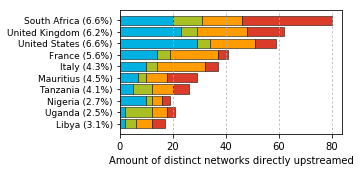

In [725]:
plt.figure(figsize=(5,2.5))

i = 0
left = 0
for cc, links in sorted(g_ases_upstreams.in_degree().items(), key=itemgetter(1), reverse=False)[-10:]:
#     print cc, links, [asn_to_cluster(asn) for asn in g_ases_upstreams.predecessors(cc)]
    
    clusters_uptreamed = [asn_to_cluster(asn) for asn in g_ases_upstreams.predecessors(cc)]
    n = len(clusters_uptreamed)
    print cc, Counter(clusters_uptreamed)
    for clus, count in Counter(clusters_uptreamed).items():
        if clus not in [0, 1, 2, 3]:
            continue
        plt.barh(
            i,
            count,
            color=cluster_colors[clus],
            linewidth=.5, edgecolor='black',
            label=['h'],
            left=left
        )
        left += count
    left = 0
    i += 1


plt.yticks(
    range(0,10),
    [("%s (%.1f%%)" % (get_name_from_cc(cc), upstreams_perc[cc])) for cc, links in sorted(g_ases_upstreams.in_degree().items(), key=itemgetter(1), reverse=False)[-10:]],
    fontsize=9
)

plt.grid(linestyle='dotted', axis='x')
plt.xlabel('Amount of distinct networks directly upstreamed')
plt.tight_layout()


plt.savefig('figs/in_degree_top10_per_cluster.png', dpi=500)
plt.savefig('figs/in_degree_top10_per_cluster.pdf', dpi=500)
plt.show()

In [835]:
from collections import defaultdict, Counter
from operator import itemgetter

for country in ['AO', 'ET']:
    _g_countries_upstreams = g_countries_upstreams.copy()
#     _g_countries_upstreams.remove_node('XX')

    paths = defaultdict(int)

    for cc, rtts in _g_countries_upstreams[country].items():
        paths[cc] = len(rtts['rtt'])

    Counter(paths)
    _sum = sum(paths.values())
    paths_relative = {}
    for cc, length in paths.iteritems():
        paths_relative[cc] = 1.0*length / _sum

    print country
    print sorted(paths_relative.items(), key=itemgetter(1), reverse=True)[:5]

AO
[(u'ZA', 0.3725895316804408), (u'GB', 0.14325068870523416), (u'US', 0.12947658402203857), (u'PT', 0.04338842975206612), (u'AO', 0.03305785123966942)]
ET
[(u'US', 0.4626865671641791), (u'ET', 0.3582089552238806), (u'ES', 0.1791044776119403)]


# Upstreams ranking

In [197]:
upstreams_ = []
iana_ranges = [0, 65333, 64601]

for tr in trs_speed[:]:
    cc_o = tr['country_origin']
    
    first_hop = tr['as_origin']
    for h in tr['hops']:
        current_hop = h['as_destination']
        if current_hop == first_hop or current_hop in iana_ranges:
            continue
        else:
            upstreams_.append(current_hop)
            break

In [198]:
from collections import Counter
from operator import itemgetter

_sorted_counter = Counter(upstreams_)
sorted_counter = sorted(_sorted_counter.items(), key=itemgetter(1), reverse=True)

In [199]:
print sorted_counter[:12]
N = sum(_sorted_counter.values())

[(174, 2689), (3356, 1920), (37100, 1845), (6762, 1730), (30844, 1547), (5511, 1009), (57023, 588), (6453, 564), (16637, 545), (5713, 529), (3491, 511), (10474, 421)]


In [208]:
import requests
import json

rdap_info = {
    174: 'Cogent Communications',
    3356: 'Level 3 Communications, Inc.',
    37100: 'SEACOMM',
    6762: 'Sparkle (TIM Group)',
    65333: 'Private IANA ASN range',
    30844: 'Liquid Telecom',
    5511: 'France Telecom (Orange)',
    57023: 'Oranlink',
    6453: 'TATA COMMUNICATIONS (AMERICA) INC',
    16637: 'MTN',
    0: 'ASN 0',
    5713: 'Telkom SA Ltd',
    
    64601: 'Private IANA ASN range',
    3491: 'PCCW Global, Inc.',
    37662: 'WIOCC',
    8881: 'Versatel',
    3257: 'GTT',
    10474: 'Optinet',
    6939: 'Hurricane Electric, Inc.',
    33567: 'Econet Telecom Lesotho (PTY) LTD'
}

In [201]:
i = 0
total = 0
for asn, count in sorted_counter[:10]:
    
    i += 1
    perc = 100.0*count / N
    total += perc
    print "%d & %s & %s & %.1f\\%% \\\\" % (i, asn, rdap_info[asn], perc)
print total

1 & 174 & Cogent Communications & 10.3\% \\
2 & 3356 & Level 3 Communications, Inc. & 7.4\% \\
3 & 37100 & SEACOMM & 7.1\% \\
4 & 6762 & Sparkle (TIM Group) & 6.6\% \\
5 & 30844 & Liquid Telecom & 5.9\% \\
6 & 5511 & France Telecom (Orange) & 3.9\% \\
7 & 57023 & Oranlink & 2.3\% \\
8 & 6453 & TATA COMMUNICATIONS (AMERICA) INC & 2.2\% \\
9 & 16637 & MTN & 2.1\% \\
10 & 5713 & Telkom SA Ltd & 2.0\% \\
49.731512734


In [202]:
from collections import Counter

x = nx.DiGraph()

hops = []
for tr in trs_speed:
    as_o = tr['as_origin']
    for h in tr['hops']:
        
        as_d = h['as_destination']
        if as_d == as_o or as_d in iana_ranges:
            continue
        
        if (as_o, as_d) not in x.edges():
            x.add_edge(as_o, as_d, weight=1, rtt=[h['min_rtt']])
        else:
            x[as_o][as_d]['weight'] += 1
            x[as_o][as_d]['rtt'].append(h['min_rtt'])
        as_o = as_d
    hops.append(cc_list)

In [611]:
from operator import itemgetter

_x = x.copy()
centrality = nx.centrality.betweenness_centrality(_x)
# centrality = nx.centrality.degree_centrality(_x)

i = 0
total = 0
for asn, central in sorted(centrality.items(), key=itemgetter(1), reverse=True)[:10]:
    
    i += 1
    print "%d & %s & %s & %.3f \\\\" % (i, asn, rdap_info[asn], central)
    total += central
print total

1 & 30844 & Liquid Telecom & 0.137 \\
2 & 174 & Cogent Communications & 0.095 \\
3 & 3356 & Level 3 Communications, Inc. & 0.087 \\
4 & 37662 & WIOCC & 0.081 \\
5 & 3491 & PCCW Global, Inc. & 0.073 \\
6 & 6762 & Sparkle (TIM Group) & 0.071 \\
7 & 37100 & SEACOMM & 0.066 \\
8 & 8881 & Versatel & 0.051 \\
9 & 5511 & France Telecom (Orange) & 0.044 \\
10 & 6939 & Hurricane Electric, Inc. & 0.039 \\
0.744632723367


In [617]:
centrality[5713]

0.019472458764535707

## Orange (AS5511)

In [512]:
cc_to_langs = defaultdict(list)

for rest in restcountries:
    cc_to_langs[rest['alpha2Code']] = rest['languages']

### Orange's predecessors

In [530]:
total = 0
fr_speaking = 0
for predecessor in x.predecessors(5511):
    ccs_ = Counter(asn_to_countries[predecessor])
    cc = ccs_.most_common(1)[0][0]
    
    if cc not in Commons.ccs:
        continue
    total += 1
        
    if 'fr' in cc_to_langs[cc]:
        fr_speaking += 1
        print cc, predecessor
print "%d (%.1f%%)" % (fr_speaking, 100.0 * fr_speaking / total)

CD 37638
ML 30985
BJ 28683
ML 21271
SN 8346
MG 37037
TD 37462
BJ 37090
CD 37483
9 (39.1%)


### French-speaking networks

In [531]:
fr_speaking = 0

for asn in x.nodes():
    cc = Counter(asn_to_countries[asn]).most_common(1)[0][0]
    
    if cc not in Commons.ccs:
        continue
        
    if 'fr' in cc_to_langs[cc]:
        fr_speaking += 1
#         print asn
print fr_speaking

53


## At a country level

In [221]:
from collections import defaultdict

asn_to_countries = defaultdict(list)

for tr in trs_speed:
    asn_to_countries[tr['as_destination']].append(tr['country_destination'])
    asn_to_countries[tr['as_origin']].append(tr['country_origin'])
    
    for h in tr['hops']:
        asn_to_countries[h['as_destination']].append(h['country_destination'])
        asn_to_countries[h['as_origin']].append(h['country_origin'])

In [225]:
from collections import Counter

y = nx.DiGraph()
banned = ['XX']
hops = []
for tr in trs_speed:
    as_o = tr['country_origin']
    for h in tr['hops']:
        
        as_d = h['country_destination']
        if as_d == as_o or as_d in banned:
            continue
        
        if (as_o, as_d) not in y.edges():
            y.add_edge(as_o, as_d, weight=1, rtt=[h['min_rtt']])
        else:
            y[as_o][as_d]['weight'] += 1
            y[as_o][as_d]['rtt'].append(h['min_rtt'])
        as_o = as_d
    hops.append(cc_list)

In [229]:
from operator import itemgetter

_x = y.copy()
# centrality = nx.centrality.betweenness_centrality(_x)
centrality = nx.centrality.degree_centrality(_x)

i = 0
total = 0
for cc, central in sorted(centrality.items(), key=itemgetter(1), reverse=True)[:10]:
    
    i += 1
    print "%d & %s & %.2f \\\\" % (i, names[cc], central)
    total += central
print total

1 & United Kingdom & 1.07 \\
2 & United States & 1.00 \\
3 & France & 0.92 \\
4 & South Africa & 0.89 \\
5 & Mauritius & 0.78 \\
6 & Italy & 0.66 \\
7 & Kenya & 0.58 \\
8 & Egypt & 0.50 \\
9 & Angola & 0.50 \\
10 & Tanzania & 0.50 \\
7.39473684211


In [ ]:
from collections import Counter

y = nx.DiGraph()
banned = ['XX']
hops = []
for tr in trs_speed:
    as_o = tr['country_origin']
    for h in tr['hops']:
        
        as_d = h['country_destination']
        if as_d == as_o or as_d in banned:
            continue
        
        if (as_o, as_d) not in y.edges():
            y.add_edge(as_o, as_d, weight=1, rtt=[h['min_rtt']])
        else:
            y[as_o][as_d]['weight'] += 1
            y[as_o][as_d]['rtt'].append(h['min_rtt'])
        as_o = as_d
    hops.append(cc_list)

## Performance implications

In [330]:
from collections import defaultdict

upstreams_countries = defaultdict(list)

banned = [0]
banned_ccs = ['XX']

for tr in trs_speed[:]:
    
    first_hop = tr['as_origin']
    cc_o = tr['country_origin']
    for h in tr['hops']:
        current_hop = h['as_destination']
        
        if current_hop == first_hop or current_hop in banned:
            continue
        else:
            cc_d = h['country_destination']
            if cc_d in banned_ccs:
                continue
            
            upstreams_countries[first_hop].append(cc_d)
            
            break

In [351]:
def asn_to_cluster(asn):
    cc = Counter(asn_to_countries[asn]).most_common(1)[0][0]
    if cc in banned_ccs or cc not in cluster_speed.keys():
        return 4
    return cluster_speed[cc]

In [362]:
from collections import Counter

african_clusters = [0, 1, 2, 3]
african = []
overseas = []
same_cluster = []
african_cluster = []
for asn, ups in upstreams_countries.iteritems():
    cluss = []
    for c in ups:
        try:
            cluss.append(cluster_speed[c])
        except:
            continue
    counter = Counter(cluss)
    n = sum(counter.values())


    upstreams_through_africa = sum([v for k, v in counter.items() if k in african_clusters])
    upstreams_through_overseas = sum([v for k, v in counter.items() if k not in african_clusters])
    
    try:
        overseas_ratio = upstreams_through_overseas / (upstreams_through_africa + upstreams_through_overseas)
    except:
        print counter
        continue
    
    if overseas_ratio > .50:
        overseas.append(asn)
    else:
        african.append(asn)
        
    this_cluster = asn_to_cluster(asn)
    if this_cluster == counter.most_common(1)[0][0]:
        same_cluster.append(asn)
    elif counter.most_common(1)[0][0] in african_clusters:
        african_cluster.append(asn)

Counter()


### Crossing it with RTT data

In [268]:
import json
import requests

j = requests.get('https://simon.lacnic.net/static/results-africa-connectivity.json').text
rs_speed = json.loads(j)

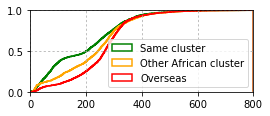

268.0 243.0 203.0


In [380]:
rtts_african = [r['min_rtt'] for r in rs_speed if r['as_origin'] in african]
rtts_overseas = [r['min_rtt'] for r in rs_speed if r['as_origin'] in overseas]
rtts_same_cluster = [r['min_rtt'] for r in rs_speed if r['as_origin'] in same_cluster]
rtts_african_cluster = [r['min_rtt'] for r in rs_speed if r['as_origin'] in african_cluster]

plt.figure(figsize=(4,1.5))
plt.hist(
    [rtts_overseas, rtts_african_cluster, rtts_same_cluster],
    histtype='step',
    linewidth=1.5,
    range=(0,800),
    bins=800,
    cumulative=True,
    normed=True,
    label=['Overseas', 'Other African cluster', 'Same cluster'],
    color=['red', 'orange', 'green']
)

plt.margins(.0)
plt.grid(linestyle='dotted')
plt.legend(loc='lower right')
plt.savefig('figs/three_scenarios.png', dpi=500, bbox_inches='tight')
plt.savefig('figs/three_scenarios.pdf', dpi=500, bbox_inches='tight')
plt.show()


print np.median(rtts_overseas), np.median(rtts_african_cluster), np.median(rtts_same_cluster)